## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


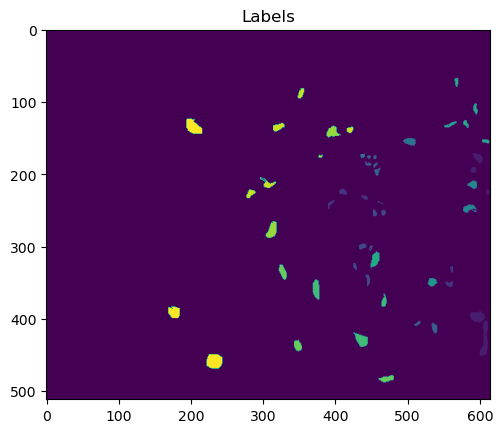

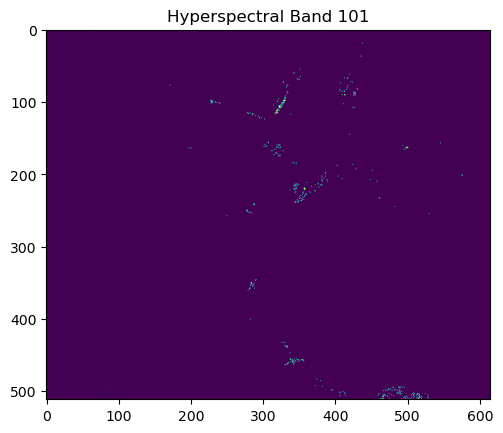

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Selected 5


All datasets saved to the 'indices' folder.
(65, 5, 5, 176)
(65, 5, 5, 176)
(5081, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 65
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2515, PSNR: 5.9945


Epoch [1/50] Training Loss: 0.2421, PSNR: 6.1613
	[Val]   Batch [1/17] Loss: 0.2315, PSNR: 6.3549
	[Val]   Batch [10/17] Loss: 0.2317, PSNR: 6.3505
Epoch [1/50] Validation Loss: 0.2316, PSNR: 6.3532

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2237, PSNR: 6.5041


Epoch [2/50] Training Loss: 0.2082, PSNR: 6.8216
	[Val]   Batch [1/17] Loss: 0.1852, PSNR: 7.3227
	[Val]   Batch [10/17] Loss: 0.1868, PSNR: 7.2851
Epoch [2/50] Validation Loss: 0.1862, PSNR: 7.2997

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1841, PSNR: 7.3502


Epoch [3/50] Training Loss: 0.1696, PSNR: 7.7137
	[Val]   Batch [1/17] Loss: 0.1474, PSNR: 8.3139
	[Val]   Batch [10/17] Loss: 0.1509, PSNR: 8.2117
Epoch [3/50] Validation Loss: 0.1495, PSNR: 8.2546

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1489, PSNR: 8.2714


Epoch [4/50] Training Loss: 0.1364, PSNR: 8.6599
	[Val]   Batch [1/17] Loss: 0.1176, PSNR: 9.2955
	[Val]   Batch [10/17] Loss: 0.1200, PSNR: 9.2097
Epoch [4/50] Validation Loss: 0.1189, PSNR: 9.2494

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1183, PSNR: 9.2715


Epoch [5/50] Training Loss: 0.1084, PSNR: 9.6592
	[Val]   Batch [1/17] Loss: 0.0954, PSNR: 10.2061
	[Val]   Batch [10/17] Loss: 0.0974, PSNR: 10.1143
Epoch [5/50] Validation Loss: 0.0966, PSNR: 10.1514

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0940, PSNR: 10.2683


Epoch [6/50] Training Loss: 0.0860, PSNR: 10.6607
	[Val]   Batch [1/17] Loss: 0.0769, PSNR: 11.1429
	[Val]   Batch [10/17] Loss: 0.0780, PSNR: 11.0817
Epoch [6/50] Validation Loss: 0.0776, PSNR: 11.1036

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0748, PSNR: 11.2604


Epoch [7/50] Training Loss: 0.0691, PSNR: 11.6135
	[Val]   Batch [1/17] Loss: 0.0624, PSNR: 12.0448
	[Val]   Batch [10/17] Loss: 0.0631, PSNR: 11.9965
Epoch [7/50] Validation Loss: 0.0630, PSNR: 12.0077

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0606, PSNR: 12.1743


Epoch [8/50] Training Loss: 0.0563, PSNR: 12.4992
	[Val]   Batch [1/17] Loss: 0.0514, PSNR: 12.8931
	[Val]   Batch [10/17] Loss: 0.0520, PSNR: 12.8432
Epoch [8/50] Validation Loss: 0.0518, PSNR: 12.8573

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0502, PSNR: 12.9894


Epoch [9/50] Training Loss: 0.0467, PSNR: 13.3127
	[Val]   Batch [1/17] Loss: 0.0437, PSNR: 13.5918
	[Val]   Batch [10/17] Loss: 0.0442, PSNR: 13.5447
Epoch [9/50] Validation Loss: 0.0440, PSNR: 13.5607

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0420, PSNR: 13.7702


Epoch [10/50] Training Loss: 0.0392, PSNR: 14.0679
	[Val]   Batch [1/17] Loss: 0.0371, PSNR: 14.3086
	[Val]   Batch [10/17] Loss: 0.0375, PSNR: 14.2582
Epoch [10/50] Validation Loss: 0.0374, PSNR: 14.2711

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0356, PSNR: 14.4827


Epoch [11/50] Training Loss: 0.0335, PSNR: 14.7484
	[Val]   Batch [1/17] Loss: 0.0317, PSNR: 14.9947
	[Val]   Batch [10/17] Loss: 0.0320, PSNR: 14.9439
Epoch [11/50] Validation Loss: 0.0319, PSNR: 14.9555

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0304, PSNR: 15.1780


Epoch [12/50] Training Loss: 0.0290, PSNR: 15.3760
	[Val]   Batch [1/17] Loss: 0.0276, PSNR: 15.5972
	[Val]   Batch [10/17] Loss: 0.0278, PSNR: 15.5643
Epoch [12/50] Validation Loss: 0.0277, PSNR: 15.5769

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0268, PSNR: 15.7196


Epoch [13/50] Training Loss: 0.0254, PSNR: 15.9566
	[Val]   Batch [1/17] Loss: 0.0247, PSNR: 16.0817
	[Val]   Batch [10/17] Loss: 0.0251, PSNR: 16.0080
Epoch [13/50] Validation Loss: 0.0249, PSNR: 16.0338

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0236, PSNR: 16.2686


Epoch [14/50] Training Loss: 0.0225, PSNR: 15.8146
	[Val]   Batch [1/17] Loss: 0.0221, PSNR: 16.5505
	[Val]   Batch [10/17] Loss: 0.0223, PSNR: 16.5210
Epoch [14/50] Validation Loss: 0.0222, PSNR: 16.5322

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0210, PSNR: 16.7875


Epoch [15/50] Training Loss: 0.0200, PSNR: 16.9823
	[Val]   Batch [1/17] Loss: 0.0197, PSNR: 17.0624
	[Val]   Batch [10/17] Loss: 0.0200, PSNR: 16.9960
Epoch [15/50] Validation Loss: 0.0199, PSNR: 17.0214

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0187, PSNR: 17.2919


Epoch [16/50] Training Loss: 0.0180, PSNR: 17.4451
	[Val]   Batch [1/17] Loss: 0.0177, PSNR: 17.5149
	[Val]   Batch [10/17] Loss: 0.0179, PSNR: 17.4630
Epoch [16/50] Validation Loss: 0.0178, PSNR: 17.4864

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0172, PSNR: 17.6396


Epoch [17/50] Training Loss: 0.0163, PSNR: 17.8810
	[Val]   Batch [1/17] Loss: 0.0161, PSNR: 17.9392
	[Val]   Batch [10/17] Loss: 0.0163, PSNR: 17.8814
Epoch [17/50] Validation Loss: 0.0162, PSNR: 17.9057

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0153, PSNR: 18.1596


Epoch [18/50] Training Loss: 0.0148, PSNR: 17.5931
	[Val]   Batch [1/17] Loss: 0.0150, PSNR: 18.2485
	[Val]   Batch [10/17] Loss: 0.0151, PSNR: 18.2063
Epoch [18/50] Validation Loss: 0.0151, PSNR: 18.2218

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0140, PSNR: 18.5415


Epoch [19/50] Training Loss: 0.0135, PSNR: 18.6842
	[Val]   Batch [1/17] Loss: 0.0135, PSNR: 18.7047
	[Val]   Batch [10/17] Loss: 0.0137, PSNR: 18.6472
Epoch [19/50] Validation Loss: 0.0136, PSNR: 18.6694

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0128, PSNR: 18.9291


Epoch [20/50] Training Loss: 0.0125, PSNR: 18.3664
	[Val]   Batch [1/17] Loss: 0.0128, PSNR: 18.9401
	[Val]   Batch [10/17] Loss: 0.0129, PSNR: 18.8812
Epoch [20/50] Validation Loss: 0.0129, PSNR: 18.9030

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0118, PSNR: 19.2638


Epoch [21/50] Training Loss: 0.0115, PSNR: 19.3826
	[Val]   Batch [1/17] Loss: 0.0115, PSNR: 19.3852
	[Val]   Batch [10/17] Loss: 0.0117, PSNR: 19.3110
Epoch [21/50] Validation Loss: 0.0116, PSNR: 19.3414

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0108, PSNR: 19.6801


Epoch [22/50] Training Loss: 0.0106, PSNR: 19.0514
	[Val]   Batch [1/17] Loss: 0.0109, PSNR: 19.6372
	[Val]   Batch [10/17] Loss: 0.0110, PSNR: 19.5706
Epoch [22/50] Validation Loss: 0.0110, PSNR: 19.5969

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0101, PSNR: 19.9428


Epoch [23/50] Training Loss: 0.0099, PSNR: 19.3709
	[Val]   Batch [1/17] Loss: 0.0100, PSNR: 20.0148
	[Val]   Batch [10/17] Loss: 0.0101, PSNR: 19.9413
Epoch [23/50] Validation Loss: 0.0101, PSNR: 19.9693

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0094, PSNR: 20.2715


Epoch [24/50] Training Loss: 0.0092, PSNR: 20.3596
	[Val]   Batch [1/17] Loss: 0.0092, PSNR: 20.3495
	[Val]   Batch [10/17] Loss: 0.0094, PSNR: 20.2724
Epoch [24/50] Validation Loss: 0.0093, PSNR: 20.3034

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0091, PSNR: 20.4128


Epoch [25/50] Training Loss: 0.0086, PSNR: 19.9682
	[Val]   Batch [1/17] Loss: 0.0088, PSNR: 20.5345
	[Val]   Batch [10/17] Loss: 0.0090, PSNR: 20.4523
Epoch [25/50] Validation Loss: 0.0090, PSNR: 20.4813

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0085, PSNR: 20.7102


Epoch [26/50] Training Loss: 0.0081, PSNR: 20.9342
	[Val]   Batch [1/17] Loss: 0.0081, PSNR: 20.9031
	[Val]   Batch [10/17] Loss: 0.0083, PSNR: 20.8243
Epoch [26/50] Validation Loss: 0.0082, PSNR: 20.8510

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0077, PSNR: 21.1353


Epoch [27/50] Training Loss: 0.0076, PSNR: 21.2056
	[Val]   Batch [1/17] Loss: 0.0076, PSNR: 21.1703
	[Val]   Batch [10/17] Loss: 0.0078, PSNR: 21.0848
Epoch [27/50] Validation Loss: 0.0077, PSNR: 21.1177

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0075, PSNR: 21.2212


Epoch [28/50] Training Loss: 0.0071, PSNR: 20.7850
	[Val]   Batch [1/17] Loss: 0.0073, PSNR: 21.3910
	[Val]   Batch [10/17] Loss: 0.0074, PSNR: 21.2931
Epoch [28/50] Validation Loss: 0.0074, PSNR: 21.3283

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0069, PSNR: 21.5959


Epoch [29/50] Training Loss: 0.0067, PSNR: 21.7160
	[Val]   Batch [1/17] Loss: 0.0068, PSNR: 21.6940
	[Val]   Batch [10/17] Loss: 0.0069, PSNR: 21.5960
Epoch [29/50] Validation Loss: 0.0069, PSNR: 21.6364

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0065, PSNR: 21.8716


Epoch [30/50] Training Loss: 0.0064, PSNR: 21.9541
	[Val]   Batch [1/17] Loss: 0.0063, PSNR: 21.9757
	[Val]   Batch [10/17] Loss: 0.0065, PSNR: 21.8622
Epoch [30/50] Validation Loss: 0.0064, PSNR: 21.9068

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0061, PSNR: 22.1391


Epoch [31/50] Training Loss: 0.0060, PSNR: 22.2072
	[Val]   Batch [1/17] Loss: 0.0061, PSNR: 22.1619
	[Val]   Batch [10/17] Loss: 0.0062, PSNR: 22.0555
Epoch [31/50] Validation Loss: 0.0062, PSNR: 22.1007

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0062, PSNR: 22.0942


Epoch [32/50] Training Loss: 0.0057, PSNR: 22.4343
	[Val]   Batch [1/17] Loss: 0.0057, PSNR: 22.4473
	[Val]   Batch [10/17] Loss: 0.0059, PSNR: 22.3240
Epoch [32/50] Validation Loss: 0.0058, PSNR: 22.3724

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0057, PSNR: 22.4125


Epoch [33/50] Training Loss: 0.0054, PSNR: 22.6609
	[Val]   Batch [1/17] Loss: 0.0055, PSNR: 22.6250
	[Val]   Batch [10/17] Loss: 0.0056, PSNR: 22.5106
Epoch [33/50] Validation Loss: 0.0056, PSNR: 22.5564

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0051, PSNR: 22.8841


Epoch [34/50] Training Loss: 0.0052, PSNR: 22.8722
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.8833
	[Val]   Batch [10/17] Loss: 0.0053, PSNR: 22.7532
Epoch [34/50] Validation Loss: 0.0052, PSNR: 22.8065

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0049, PSNR: 23.0669


Epoch [35/50] Training Loss: 0.0049, PSNR: 23.0926
	[Val]   Batch [1/17] Loss: 0.0050, PSNR: 23.0517
	[Val]   Batch [10/17] Loss: 0.0051, PSNR: 22.9192
Epoch [35/50] Validation Loss: 0.0050, PSNR: 22.9746

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0046, PSNR: 23.3317


Epoch [36/50] Training Loss: 0.0047, PSNR: 23.2832
	[Val]   Batch [1/17] Loss: 0.0047, PSNR: 23.2711
	[Val]   Batch [10/17] Loss: 0.0049, PSNR: 23.1302
Epoch [36/50] Validation Loss: 0.0048, PSNR: 23.1855

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0044, PSNR: 23.5166


Epoch [37/50] Training Loss: 0.0045, PSNR: 23.4896
	[Val]   Batch [1/17] Loss: 0.0045, PSNR: 23.4522
	[Val]   Batch [10/17] Loss: 0.0047, PSNR: 23.3072
Epoch [37/50] Validation Loss: 0.0046, PSNR: 23.3672

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6856


Epoch [38/50] Training Loss: 0.0043, PSNR: 23.6759
	[Val]   Batch [1/17] Loss: 0.0043, PSNR: 23.6566
	[Val]   Batch [10/17] Loss: 0.0045, PSNR: 23.4910
Epoch [38/50] Validation Loss: 0.0044, PSNR: 23.5562

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.8665


Epoch [39/50] Training Loss: 0.0041, PSNR: 23.8654
	[Val]   Batch [1/17] Loss: 0.0041, PSNR: 23.8347
	[Val]   Batch [10/17] Loss: 0.0043, PSNR: 23.6718
Epoch [39/50] Validation Loss: 0.0042, PSNR: 23.7362

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 24.0067


Epoch [40/50] Training Loss: 0.0039, PSNR: 23.3633
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9654
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7951
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.8610

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 23.9267


Epoch [41/50] Training Loss: 0.0038, PSNR: 24.2315
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.1445
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9648
Epoch [41/50] Validation Loss: 0.0039, PSNR: 24.0366

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.4156


Epoch [42/50] Training Loss: 0.0036, PSNR: 23.7266
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.3049
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.1209
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.1956

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.2667


Epoch [43/50] Training Loss: 0.0035, PSNR: 24.5852
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5884
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.3951
Epoch [43/50] Validation Loss: 0.0036, PSNR: 24.4719

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.7155


Epoch [44/50] Training Loss: 0.0034, PSNR: 24.7493
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.7460
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.5568
Epoch [44/50] Validation Loss: 0.0034, PSNR: 24.6341

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9468


Epoch [45/50] Training Loss: 0.0032, PSNR: 24.2358
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.8764
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.6679
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.7474

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.0360


Epoch [46/50] Training Loss: 0.0031, PSNR: 25.0739
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.0797
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.8724
Epoch [46/50] Validation Loss: 0.0032, PSNR: 24.9552

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9610


Epoch [47/50] Training Loss: 0.0030, PSNR: 24.5479
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.1667
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9538
Epoch [47/50] Validation Loss: 0.0031, PSNR: 25.0363

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3719


Epoch [48/50] Training Loss: 0.0029, PSNR: 25.3672
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3664
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.1473
Epoch [48/50] Validation Loss: 0.0030, PSNR: 25.2345

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0027, PSNR: 25.6587


Epoch [49/50] Training Loss: 0.0028, PSNR: 25.5389
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5488
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3205
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.4086

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.1457


Epoch [50/50] Training Loss: 0.0027, PSNR: 25.6793
	[Val]   Batch [1/17] Loss: 0.0027, PSNR: 25.6995
	[Val]   Batch [10/17] Loss: 0.0028, PSNR: 25.4585
Epoch [50/50] Validation Loss: 0.0028, PSNR: 25.5529


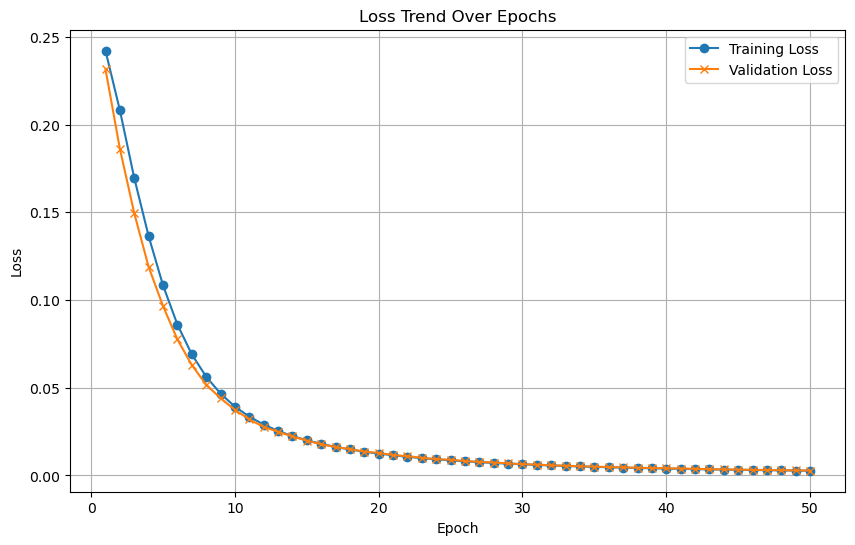

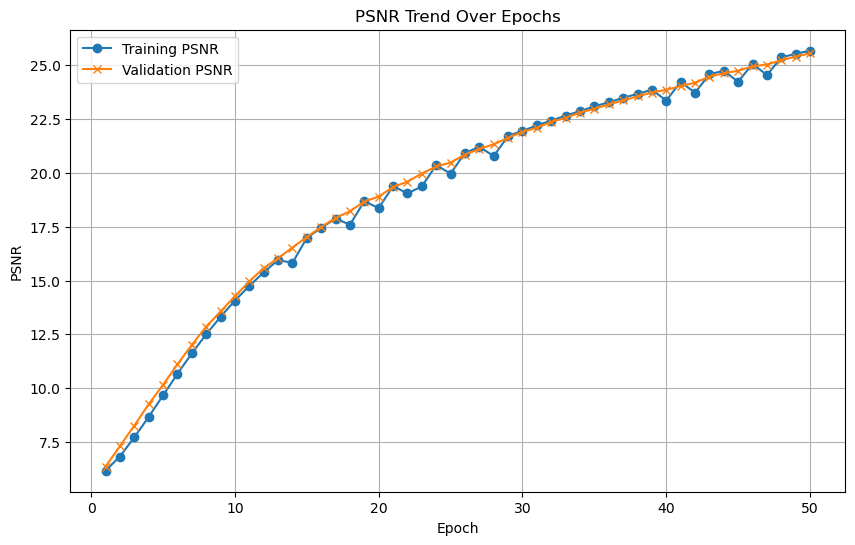

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5851
    Validation Batch [1/1], Loss: 2.5721
Validation Loss: 2.5721, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5721. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5690
    Validation Batch [1/1], Loss: 2.5721
Validation Loss: 2.5721, Validation Accuracy: 7.69%
Validation loss improved from 2.5721 to 2.5721. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5593
    Validation Batch [1/1], Loss: 2.5721
Validation Loss: 2.5721, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5405
    Validation Batch [1/1], Loss: 2.5721
Validation Loss: 2.5721, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] comple

Epoch [23/1000] completed, Average Training Loss: 2.3974
    Validation Batch [1/1], Loss: 2.5727
Validation Loss: 2.5727, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.4133
    Validation Batch [1/1], Loss: 2.5727
Validation Loss: 2.5727, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.3919
    Validation Batch [1/1], Loss: 2.5727
Validation Loss: 2.5727, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.3807
    Validation Batch [1/1], Loss: 2.5727
Validation Loss: 2.5727, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.3940
    Validat

    Validation Batch [1/1], Loss: 2.5651
Validation Loss: 2.5651, Validation Accuracy: 13.85%
Validation loss improved from 2.5659 to 2.5651. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.1778
    Validation Batch [1/1], Loss: 2.5643
Validation Loss: 2.5643, Validation Accuracy: 13.85%
Validation loss improved from 2.5651 to 2.5643. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.1534
    Validation Batch [1/1], Loss: 2.5633
Validation Loss: 2.5633, Validation Accuracy: 16.92%
Validation loss improved from 2.5643 to 2.5633. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 2.1832
    Validation Batch [1/1], Loss: 2.5622
Validation Loss: 2.5622, Validation Accuracy: 16.92%
Validation loss improved from 2.5633 to 2.5622. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 2.1698
    Vali

Epoch [84/1000] completed, Average Training Loss: 2.0009
    Validation Batch [1/1], Loss: 2.4258
Validation Loss: 2.4258, Validation Accuracy: 18.46%
Validation loss improved from 2.4375 to 2.4258. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.9144
    Validation Batch [1/1], Loss: 2.4125
Validation Loss: 2.4125, Validation Accuracy: 18.46%
Validation loss improved from 2.4258 to 2.4125. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.9195
    Validation Batch [1/1], Loss: 2.3994
Validation Loss: 2.3994, Validation Accuracy: 18.46%
Validation loss improved from 2.4125 to 2.3994. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.9255
    Validation Batch [1/1], Loss: 2.3861
Validation Loss: 2.3861, Validation Accuracy: 18.46%
Validation loss improved from 2.3994 to 2.3861. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [8


LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.7004
    Validation Batch [1/1], Loss: 2.1462
Validation Loss: 2.1462, Validation Accuracy: 53.85%
Validation loss improved from 2.1474 to 2.1462. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.7532
    Validation Batch [1/1], Loss: 2.1394
Validation Loss: 2.1394, Validation Accuracy: 52.31%
Validation loss improved from 2.1462 to 2.1394. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.6557
    Validation Batch [1/1], Loss: 2.1328
Validation Loss: 2.1328, Validation Accuracy: 46.15%
Validation loss improved from 2.1394 to 2.1328. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.6791
    Validation Batch [1/1], Loss: 2.1272
Validation Loss: 2.1272, Validation Accuracy: 44.62%
Validation loss improved from 2.1328 to 2.1272. Saving model...


Epoch [146/1000] completed, Average Training Loss: 1.4181
    Validation Batch [1/1], Loss: 2.0469
Validation Loss: 2.0469, Validation Accuracy: 63.08%
Validation loss improved from 2.0546 to 2.0469. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.4941
    Validation Batch [1/1], Loss: 2.0386
Validation Loss: 2.0386, Validation Accuracy: 63.08%
Validation loss improved from 2.0469 to 2.0386. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.3597
    Validation Batch [1/1], Loss: 2.0557
Validation Loss: 2.0557, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.4031
    Validation Batch [1/1], Loss: 2.0735
Validation Loss: 2.0735, Validation Accuracy: 56.92%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Av

Epoch [178/1000] completed, Average Training Loss: 1.0835
    Validation Batch [1/1], Loss: 1.9489
Validation Loss: 1.9489, Validation Accuracy: 58.46%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.0901
    Validation Batch [1/1], Loss: 1.9174
Validation Loss: 1.9174, Validation Accuracy: 60.00%
Validation loss improved from 1.9319 to 1.9174. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.1232
    Validation Batch [1/1], Loss: 1.9167
Validation Loss: 1.9167, Validation Accuracy: 64.62%
Validation loss improved from 1.9174 to 1.9167. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.0771
    Validation Batch [1/1], Loss: 1.9538
Validation Loss: 1.9538, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Av

    Validation Batch [1/1], Loss: 1.9181
Validation Loss: 1.9181, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.8588
    Validation Batch [1/1], Loss: 1.9131
Validation Loss: 1.9131, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.7840
    Validation Batch [1/1], Loss: 1.9029
Validation Loss: 1.9029, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.9070
    Validation Batch [1/1], Loss: 1.9102
Validation Loss: 1.9102, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.8452
    Validation Batch [1/1], Loss: 1.9191
Validation Loss

Epoch [238/1000] completed, Average Training Loss: 0.6781
    Validation Batch [1/1], Loss: 1.8609
Validation Loss: 1.8609, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.6712
    Validation Batch [1/1], Loss: 1.8480
Validation Loss: 1.8480, Validation Accuracy: 63.08%
Validation loss improved from 1.8530 to 1.8480. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.6318
    Validation Batch [1/1], Loss: 1.8553
Validation Loss: 1.8553, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.6478
    Validation Batch [1/1], Loss: 1.8591
Validation Loss: 1.8591, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training

Epoch [269/1000] completed, Average Training Loss: 0.5079
    Validation Batch [1/1], Loss: 1.8841
Validation Loss: 1.8841, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.4600
    Validation Batch [1/1], Loss: 1.8880
Validation Loss: 1.8880, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.4578
    Validation Batch [1/1], Loss: 1.8878
Validation Loss: 1.8878, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.4859
    Validation Batch [1/1], Loss: 1.8885
Validation Loss: 1.8885, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.422

    Validation Batch [1/1], Loss: 1.9132
Validation Loss: 1.9132, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.3280
    Validation Batch [1/1], Loss: 1.9099
Validation Loss: 1.9099, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.3500
    Validation Batch [1/1], Loss: 1.9244
Validation Loss: 1.9244, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3582
    Validation Batch [1/1], Loss: 1.9320
Validation Loss: 1.9320, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.3412
    Validation Batch [1/1], Loss: 1.9352
Validation Loss

Epoch [336/1000] completed, Average Training Loss: 0.3106
    Validation Batch [1/1], Loss: 1.9769
Validation Loss: 1.9769, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.2579
    Validation Batch [1/1], Loss: 1.9819
Validation Loss: 1.9819, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.2551
    Validation Batch [1/1], Loss: 1.9690
Validation Loss: 1.9690, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.2756
    Validation Batch [1/1], Loss: 1.9579
Validation Loss: 1.9579, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.264

Epoch [367/1000] completed, Average Training Loss: 0.2291
    Validation Batch [1/1], Loss: 2.0453
Validation Loss: 2.0453, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.1924
    Validation Batch [1/1], Loss: 2.0554
Validation Loss: 2.0554, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.2188
    Validation Batch [1/1], Loss: 2.0649
Validation Loss: 2.0649, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.1804
    Validation Batch [1/1], Loss: 2.0585
Validation Loss: 2.0585, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.196

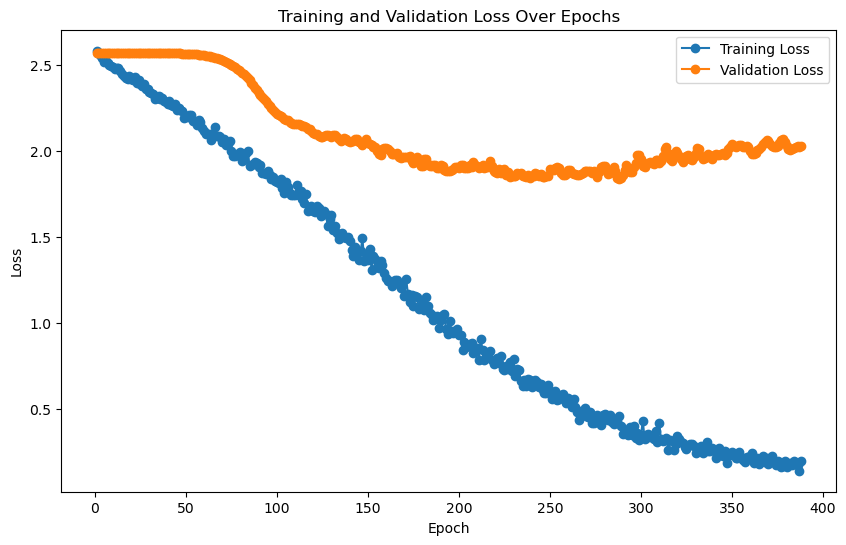

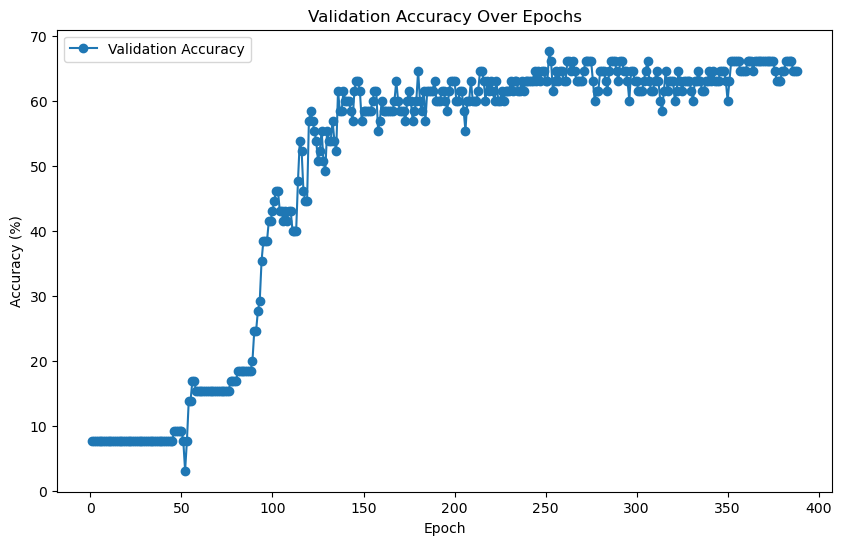


Evaluating on the test set...
    Test Batch [1/20], Loss: 1.2517

Final Test Loss: 1.4827, Test Accuracy: 67.35%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.


  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)

LOG: Training features shape: (65, 64), Training labels shape: (65,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (5081, 64), Test labels shape: (5081,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 29.23%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.40      0.29         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.50      0.60      0.55         5
           5       0.33      0.80      0.47         5
           6       1.00      0.20      0.33         5
           7       0.23      0.60      0.33         5
           8       0.36      0.80    

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)
Train reps shape: (65, 64)
Train labels shape: (65,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (5081, 64)
Test labels shape: (5081,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6396  |  Val Loss: 2.6527
Validation loss improved from inf to 2.6527.
[Epoch 2/1000] Train Loss: 2.5905  |  Val Loss: 2.6293
Validation loss improved from 2.6527 to 2.6293.
[Epoch 3/1000] Train Loss: 2.5799  |  Val Loss: 2.6219
Validation loss improved from 2.6293 to 2.6219.
[Epoch 4/1000] Train Loss: 2.5766  |  Val Loss: 2.6208
Validation loss improved from 2.6219 to 2.6208.
[Epoch 5/1000] Train Loss: 2.5748  |  Val Loss: 2.6233
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 6/1000] Train Loss: 2.5694  |  Val Loss: 2.6334
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 7/1000] Train Loss: 2.5669  |  Val Loss: 2.6403
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 8/1000] Train Loss: 2.5640  |  Val Loss: 2.6428
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 9/1000] Train Loss: 2.5584  |  Val Loss: 2.6435
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 10/1000] Train Loss: 2.5529  |  Val Los

[Epoch 26/1000] Train Loss: 2.4753  |  Val Loss: 2.6832
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 27/1000] Train Loss: 2.4730  |  Val Loss: 2.6896
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 28/1000] Train Loss: 2.4705  |  Val Loss: 2.6908
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 29/1000] Train Loss: 2.4694  |  Val Loss: 2.6940
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 30/1000] Train Loss: 2.4690  |  Val Loss: 2.7008
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 31/1000] Train Loss: 2.4682  |  Val Loss: 2.7112
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 32/1000] Train Loss: 2.4703  |  Val Loss: 2.7234
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 33/1000] Train Loss: 2.4702  |  Val Loss: 2.7361
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 34/1000] Train Loss: 2.4681  |  Val Loss: 2.7472
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 35/1000] Train Loss: 2.4646  |  Val Loss: 2.7569
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 36/1000] Train Loss: 2.4611  |  Val Loss: 2.7665
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 37/1000] Train Loss: 2.4592  |  Val Loss: 2.7865
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 38/1000] Train Loss: 2.4574  |  Val Loss: 2.8091
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 39/1000] Train Loss: 2.4528  |  Val Loss: 2.8261
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 40/1000] Train Loss: 2.4489  |  Val Loss: 2.8358
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 41/1000] Train Loss: 2.4434  |  Val Loss: 2.8414
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 42/1000] Train Loss: 2.4390  |  Val Loss: 2.8490
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 43/1000] Train Loss: 2.4372  |  Val Loss: 2.8583
!! Validation loss did NOT improve !! Patience: 39/100
[

[Epoch 69/1000] Train Loss: 2.4003  |  Val Loss: 2.8667
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 70/1000] Train Loss: 2.3984  |  Val Loss: 2.8917
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 71/1000] Train Loss: 2.3964  |  Val Loss: 2.9102
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 72/1000] Train Loss: 2.3927  |  Val Loss: 2.9216
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 73/1000] Train Loss: 2.3883  |  Val Loss: 2.9339
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 74/1000] Train Loss: 2.3857  |  Val Loss: 2.9461
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 75/1000] Train Loss: 2.3827  |  Val Loss: 2.9589
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 76/1000] Train Loss: 2.3783  |  Val Loss: 2.9732
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 77/1000] Train Loss: 2.3739  |  Val Loss: 2.9851
!! Validation loss did NOT improve !! Patience: 73/100
[

[Epoch 82/1000] Train Loss: 2.3578  |  Val Loss: 2.9889
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 83/1000] Train Loss: 2.3560  |  Val Loss: 2.9816
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 84/1000] Train Loss: 2.3562  |  Val Loss: 2.9800
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 85/1000] Train Loss: 2.3554  |  Val Loss: 2.9884
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 86/1000] Train Loss: 2.3604  |  Val Loss: 3.0078
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 87/1000] Train Loss: 2.3696  |  Val Loss: 3.0451
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 88/1000] Train Loss: 2.3915  |  Val Loss: 3.0871
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 89/1000] Train Loss: 2.4154  |  Val Loss: 3.1009
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 90/1000] Train Loss: 2.4110  |  Val Loss: 3.0963
!! Validation loss did NOT improve !! Patience: 86/100
[

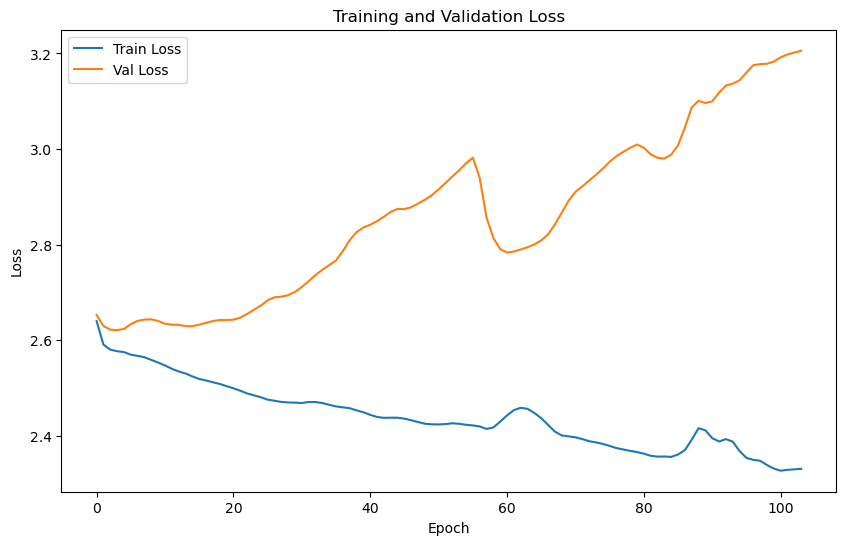

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.6832 | Test Accuracy: 7.58%


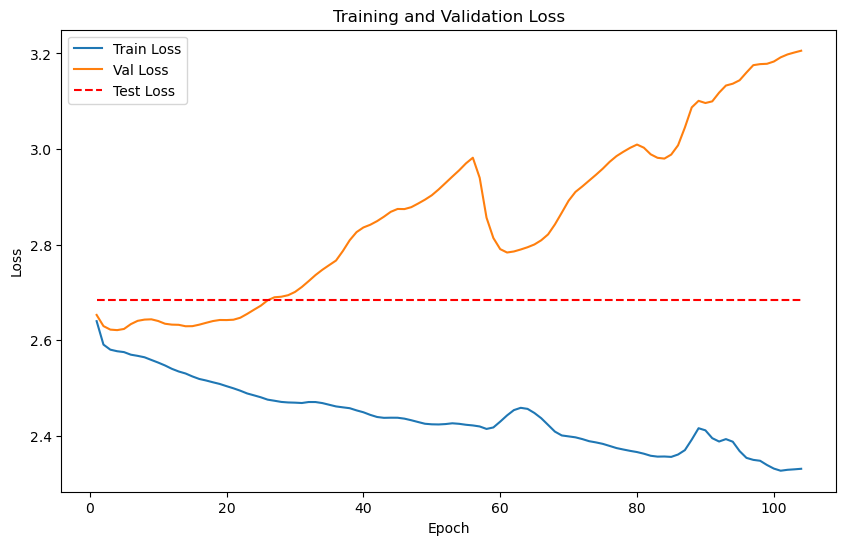

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)


Train embeddings shape: (65, 64), 
Train labels shape: (65,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5081, 64), 
Test labels shape: (5081,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}
Training batch size: 65


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.6879
Epoch [1/2000], Avg Train Loss: 8.6879
Epoch [1/2000], Avg Val Loss: 5.7042
Validation loss improved from inf to 5.7042. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.3699
Epoch [2/2000], Avg Train Loss: 8.3699
Epoch [2/2000], Avg Val Loss: 5.6782
Validation loss improved from 5.7042 to 5.6782. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.5218
Epoch [3/2000], Avg Train Loss: 8.5218
Epoch [3/2000], Avg Val Loss: 5.6511
Validation loss improved from 5.6782 to 5.6511. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.3225
Epoch [4/2000], Avg Train Loss: 8.3225
Epoch [4/2000], Avg Val Loss: 5.6245
Validation loss improved from 5.6511 to 5.6245. Saving model...

LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 8.5748
Epoch [5/2000], Avg Train Loss: 8.5748
Epoch [5/2000], Avg Val Loss: 5.5983
Validation loss improved from 5.6245 to 5.5983. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.2018
Epoch [6/2000], Avg Train Loss: 8.2018
Epoch [6/2000], Avg Val Loss: 5.5728
Validation loss improved from 5.5983 to 5.5728. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 8.1928
Epoch [7/2000], Avg Train Loss: 8.1928
Epoch [7/2000], Avg Val Loss: 5.5476
Validation loss improved from 5.5728 to 5.5476. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 8.0970
Epoch [8/2000], Avg Train Loss: 8.0970
Epoch [8/2000], Avg Val Loss: 5.5224
Validation loss improved from 5.5476 to 5.5224. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 8.1496
Epoch [9/2000], Avg Train Loss: 8.1496
Epoch [9/2000], Avg Val Loss: 5.4972
Validation loss improved from 5.5224 to 5.4972. Saving m

    Batch [1/1], Train Loss: 7.1182
Epoch [20/2000], Avg Train Loss: 7.1182
Epoch [20/2000], Avg Val Loss: 5.2318
Validation loss improved from 5.2553 to 5.2318. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.2946
Epoch [21/2000], Avg Train Loss: 7.2946
Epoch [21/2000], Avg Val Loss: 5.2084
Validation loss improved from 5.2318 to 5.2084. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.1350
Epoch [22/2000], Avg Train Loss: 7.1350
Epoch [22/2000], Avg Val Loss: 5.1850
Validation loss improved from 5.2084 to 5.1850. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.0918
Epoch [23/2000], Avg Train Loss: 7.0918
Epoch [23/2000], Avg Val Loss: 5.1618
Validation loss improved from 5.1850 to 5.1618. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.9352
Epoch [24/2000], Avg Train Loss: 6.9352
Epoch [24/2000], Avg Val Loss: 5.1385
Validation loss improved from 5.1618 to 5.

    Batch [1/1], Train Loss: 6.8608
Epoch [31/2000], Avg Train Loss: 6.8608
Epoch [31/2000], Avg Val Loss: 4.9783
Validation loss improved from 5.0007 to 4.9783. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.5824
Epoch [32/2000], Avg Train Loss: 6.5824
Epoch [32/2000], Avg Val Loss: 4.9559
Validation loss improved from 4.9783 to 4.9559. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.7146
Epoch [33/2000], Avg Train Loss: 6.7146
Epoch [33/2000], Avg Val Loss: 4.9339
Validation loss improved from 4.9559 to 4.9339. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.6859
Epoch [34/2000], Avg Train Loss: 6.6859
Epoch [34/2000], Avg Val Loss: 4.9121
Validation loss improved from 4.9339 to 4.9121. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.5421
Epoch [35/2000], Avg Train Loss: 6.5421
Epoch [35/2000], Avg Val Loss: 4.8906
Validation loss improved from 4.9121 to 4.

Epoch [48/2000], Avg Val Loss: 4.6323
Validation loss improved from 4.6507 to 4.6323. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.0179
Epoch [49/2000], Avg Train Loss: 6.0179
Epoch [49/2000], Avg Val Loss: 4.6143
Validation loss improved from 4.6323 to 4.6143. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.8507
Epoch [50/2000], Avg Train Loss: 5.8507
Epoch [50/2000], Avg Val Loss: 4.5965
Validation loss improved from 4.6143 to 4.5965. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.8325
Epoch [51/2000], Avg Train Loss: 5.8325
Epoch [51/2000], Avg Val Loss: 4.5790
Validation loss improved from 4.5965 to 4.5790. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.9822
Epoch [52/2000], Avg Train Loss: 5.9822
Epoch [52/2000], Avg Val Loss: 4.5618
Validation loss improved from 4.5790 to 4.5618. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.1224
Epoch [70/2000], Avg Train Loss: 5.1224
Epoch [70/2000], Avg Val Loss: 4.3092
Validation loss improved from 4.3206 to 4.3092. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.4206
Epoch [71/2000], Avg Train Loss: 5.4206
Epoch [71/2000], Avg Val Loss: 4.2981
Validation loss improved from 4.3092 to 4.2981. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.2542
Epoch [72/2000], Avg Train Loss: 5.2542
Epoch [72/2000], Avg Val Loss: 4.2874
Validation loss improved from 4.2981 to 4.2874. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.3669
Epoch [73/2000], Avg Train Loss: 5.3669
Epoch [73/2000], Avg Val Loss: 4.2768
Validation loss improved from 4.2874 to 4.2768. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.3163
Epoch [74/2000], Avg Train Loss: 5.3163
Epoch [74/2000], Avg Val Loss: 4.2664
Validation loss improved from 4.2768 to 4.

    Batch [1/1], Train Loss: 5.2700
Epoch [79/2000], Avg Train Loss: 5.2700
Epoch [79/2000], Avg Val Loss: 4.2183
Validation loss improved from 4.2274 to 4.2183. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.1186
Epoch [80/2000], Avg Train Loss: 5.1186
Epoch [80/2000], Avg Val Loss: 4.2095
Validation loss improved from 4.2183 to 4.2095. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.1309
Epoch [81/2000], Avg Train Loss: 5.1309
Epoch [81/2000], Avg Val Loss: 4.2010
Validation loss improved from 4.2095 to 4.2010. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.0509
Epoch [82/2000], Avg Train Loss: 5.0509
Epoch [82/2000], Avg Val Loss: 4.1925
Validation loss improved from 4.2010 to 4.1925. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.1612
Epoch [83/2000], Avg Train Loss: 5.1612
Epoch [83/2000], Avg Val Loss: 4.1844
Validation loss improved from 4.1925 to 4.

    Batch [1/1], Train Loss: 4.8242
Epoch [96/2000], Avg Train Loss: 4.8242
Epoch [96/2000], Avg Val Loss: 4.1003
Validation loss improved from 4.1057 to 4.1003. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.8398
Epoch [97/2000], Avg Train Loss: 4.8398
Epoch [97/2000], Avg Val Loss: 4.0952
Validation loss improved from 4.1003 to 4.0952. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.8923
Epoch [98/2000], Avg Train Loss: 4.8923
Epoch [98/2000], Avg Val Loss: 4.0901
Validation loss improved from 4.0952 to 4.0901. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.7811
Epoch [99/2000], Avg Train Loss: 4.7811
Epoch [99/2000], Avg Val Loss: 4.0852
Validation loss improved from 4.0901 to 4.0852. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.8115
Epoch [100/2000], Avg Train Loss: 4.8115
Epoch [100/2000], Avg Val Loss: 4.0804
Validation loss improved from 4.0852 to

    Batch [1/1], Train Loss: 4.5564
Epoch [117/2000], Avg Train Loss: 4.5564
Epoch [117/2000], Avg Val Loss: 4.0134
Validation loss improved from 4.0167 to 4.0134. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.6000
Epoch [118/2000], Avg Train Loss: 4.6000
Epoch [118/2000], Avg Val Loss: 4.0103
Validation loss improved from 4.0134 to 4.0103. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.5549
Epoch [119/2000], Avg Train Loss: 4.5549
Epoch [119/2000], Avg Val Loss: 4.0072
Validation loss improved from 4.0103 to 4.0072. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.4694
Epoch [120/2000], Avg Train Loss: 4.4694
Epoch [120/2000], Avg Val Loss: 4.0042
Validation loss improved from 4.0072 to 4.0042. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.5255
Epoch [121/2000], Avg Train Loss: 4.5255
Epoch [121/2000], Avg Val Loss: 4.0013
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4767
Epoch [129/2000], Avg Train Loss: 4.4767
Epoch [129/2000], Avg Val Loss: 3.9799
Validation loss improved from 3.9824 to 3.9799. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.5399
Epoch [130/2000], Avg Train Loss: 4.5399
Epoch [130/2000], Avg Val Loss: 3.9774
Validation loss improved from 3.9799 to 3.9774. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.5431
Epoch [131/2000], Avg Train Loss: 4.5431
Epoch [131/2000], Avg Val Loss: 3.9750
Validation loss improved from 3.9774 to 3.9750. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.3877
Epoch [132/2000], Avg Train Loss: 4.3877
Epoch [132/2000], Avg Val Loss: 3.9727
Validation loss improved from 3.9750 to 3.9727. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.5317
Epoch [133/2000], Avg Train Loss: 4.5317
Epoch [133/2000], Avg Val Loss: 3.9703
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4211
Epoch [147/2000], Avg Train Loss: 4.4211
Epoch [147/2000], Avg Val Loss: 3.9406
Validation loss improved from 3.9426 to 3.9406. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.3847
Epoch [148/2000], Avg Train Loss: 4.3847
Epoch [148/2000], Avg Val Loss: 3.9388
Validation loss improved from 3.9406 to 3.9388. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.3151
Epoch [149/2000], Avg Train Loss: 4.3151
Epoch [149/2000], Avg Val Loss: 3.9369
Validation loss improved from 3.9388 to 3.9369. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.4597
Epoch [150/2000], Avg Train Loss: 4.4597
Epoch [150/2000], Avg Val Loss: 3.9351
Validation loss improved from 3.9369 to 3.9351. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.3376
Epoch [151/2000], Avg Train Loss: 4.3376
Epoch [151/2000], Avg Val Loss: 3.9334
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3319
Epoch [164/2000], Avg Train Loss: 4.3319
Epoch [164/2000], Avg Val Loss: 3.9100
Validation loss improved from 3.9118 to 3.9100. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 4.1878
Epoch [165/2000], Avg Train Loss: 4.1878
Epoch [165/2000], Avg Val Loss: 3.9082
Validation loss improved from 3.9100 to 3.9082. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 4.3393
Epoch [166/2000], Avg Train Loss: 4.3393
Epoch [166/2000], Avg Val Loss: 3.9064
Validation loss improved from 3.9082 to 3.9064. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 4.2110
Epoch [167/2000], Avg Train Loss: 4.2110
Epoch [167/2000], Avg Val Loss: 3.9046
Validation loss improved from 3.9064 to 3.9046. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 4.2298
Epoch [168/2000], Avg Train Loss: 4.2298
Epoch [168/2000], Avg Val Loss: 3.9029
Validation loss improved fro

Epoch [172/2000], Avg Val Loss: 3.8962
Validation loss improved from 3.8979 to 3.8962. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 4.3239
Epoch [173/2000], Avg Train Loss: 4.3239
Epoch [173/2000], Avg Val Loss: 3.8946
Validation loss improved from 3.8962 to 3.8946. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.1754
Epoch [174/2000], Avg Train Loss: 4.1754
Epoch [174/2000], Avg Val Loss: 3.8930
Validation loss improved from 3.8946 to 3.8930. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.2915
Epoch [175/2000], Avg Train Loss: 4.2915
Epoch [175/2000], Avg Val Loss: 3.8913
Validation loss improved from 3.8930 to 3.8913. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.3323
Epoch [176/2000], Avg Train Loss: 4.3323
Epoch [176/2000], Avg Val Loss: 3.8897
Validation loss improved from 3.8913 to 3.8897. Saving model...

LOG: Epoch [177/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1422
Epoch [193/2000], Avg Train Loss: 4.1422
Epoch [193/2000], Avg Val Loss: 3.8631
Validation loss improved from 3.8646 to 3.8631. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.2219
Epoch [194/2000], Avg Train Loss: 4.2219
Epoch [194/2000], Avg Val Loss: 3.8615
Validation loss improved from 3.8631 to 3.8615. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.1282
Epoch [195/2000], Avg Train Loss: 4.1282
Epoch [195/2000], Avg Val Loss: 3.8600
Validation loss improved from 3.8615 to 3.8600. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.0350
Epoch [196/2000], Avg Train Loss: 4.0350
Epoch [196/2000], Avg Val Loss: 3.8584
Validation loss improved from 3.8600 to 3.8584. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 4.1018
Epoch [197/2000], Avg Train Loss: 4.1018
Epoch [197/2000], Avg Val Loss: 3.8569
Validation loss improved fro

Epoch [210/2000], Avg Val Loss: 3.8386
Validation loss improved from 3.8399 to 3.8386. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 4.1387
Epoch [211/2000], Avg Train Loss: 4.1387
Epoch [211/2000], Avg Val Loss: 3.8372
Validation loss improved from 3.8386 to 3.8372. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 4.1238
Epoch [212/2000], Avg Train Loss: 4.1238
Epoch [212/2000], Avg Val Loss: 3.8358
Validation loss improved from 3.8372 to 3.8358. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 4.1470
Epoch [213/2000], Avg Train Loss: 4.1470
Epoch [213/2000], Avg Val Loss: 3.8345
Validation loss improved from 3.8358 to 3.8345. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 4.1241
Epoch [214/2000], Avg Train Loss: 4.1241
Epoch [214/2000], Avg Val Loss: 3.8331
Validation loss improved from 3.8345 to 3.8331. Saving model...

LOG: Epoch [215/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1587
Epoch [220/2000], Avg Train Loss: 4.1587
Epoch [220/2000], Avg Val Loss: 3.8251
Validation loss improved from 3.8265 to 3.8251. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.0819
Epoch [221/2000], Avg Train Loss: 4.0819
Epoch [221/2000], Avg Val Loss: 3.8238
Validation loss improved from 3.8251 to 3.8238. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.1506
Epoch [222/2000], Avg Train Loss: 4.1506
Epoch [222/2000], Avg Val Loss: 3.8225
Validation loss improved from 3.8238 to 3.8225. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 4.0973
Epoch [223/2000], Avg Train Loss: 4.0973
Epoch [223/2000], Avg Val Loss: 3.8211
Validation loss improved from 3.8225 to 3.8211. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 4.0683
Epoch [224/2000], Avg Train Loss: 4.0683
Epoch [224/2000], Avg Val Loss: 3.8197
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0153
Epoch [240/2000], Avg Train Loss: 4.0153
Epoch [240/2000], Avg Val Loss: 3.7983
Validation loss improved from 3.7996 to 3.7983. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 4.0261
Epoch [241/2000], Avg Train Loss: 4.0261
Epoch [241/2000], Avg Val Loss: 3.7970
Validation loss improved from 3.7983 to 3.7970. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 4.0472
Epoch [242/2000], Avg Train Loss: 4.0472
Epoch [242/2000], Avg Val Loss: 3.7957
Validation loss improved from 3.7970 to 3.7957. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 4.0755
Epoch [243/2000], Avg Train Loss: 4.0755
Epoch [243/2000], Avg Val Loss: 3.7945
Validation loss improved from 3.7957 to 3.7945. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 4.0587
Epoch [244/2000], Avg Train Loss: 4.0587
Epoch [244/2000], Avg Val Loss: 3.7932
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9517
Epoch [255/2000], Avg Train Loss: 3.9517
Epoch [255/2000], Avg Val Loss: 3.7808
Validation loss improved from 3.7819 to 3.7808. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 4.0048
Epoch [256/2000], Avg Train Loss: 4.0048
Epoch [256/2000], Avg Val Loss: 3.7797
Validation loss improved from 3.7808 to 3.7797. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 3.9668
Epoch [257/2000], Avg Train Loss: 3.9668
Epoch [257/2000], Avg Val Loss: 3.7786
Validation loss improved from 3.7797 to 3.7786. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 3.9820
Epoch [258/2000], Avg Train Loss: 3.9820
Epoch [258/2000], Avg Val Loss: 3.7776
Validation loss improved from 3.7786 to 3.7776. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.0217
Epoch [259/2000], Avg Train Loss: 4.0217
Epoch [259/2000], Avg Val Loss: 3.7766
Validation loss improved fro

Epoch [266/2000], Avg Val Loss: 3.7691
Validation loss improved from 3.7703 to 3.7691. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 3.9498
Epoch [267/2000], Avg Train Loss: 3.9498
Epoch [267/2000], Avg Val Loss: 3.7680
Validation loss improved from 3.7691 to 3.7680. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 3.9490
Epoch [268/2000], Avg Train Loss: 3.9490
Epoch [268/2000], Avg Val Loss: 3.7669
Validation loss improved from 3.7680 to 3.7669. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.0101
Epoch [269/2000], Avg Train Loss: 4.0101
Epoch [269/2000], Avg Val Loss: 3.7659
Validation loss improved from 3.7669 to 3.7659. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 3.9771
Epoch [270/2000], Avg Train Loss: 3.9771
Epoch [270/2000], Avg Val Loss: 3.7648
Validation loss improved from 3.7659 to 3.7648. Saving model...

LOG: Epoch [271/2000] - Training
    Bat

Epoch [285/2000], Avg Val Loss: 3.7486
Validation loss improved from 3.7495 to 3.7486. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 3.9232
Epoch [286/2000], Avg Train Loss: 3.9232
Epoch [286/2000], Avg Val Loss: 3.7476
Validation loss improved from 3.7486 to 3.7476. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 3.9503
Epoch [287/2000], Avg Train Loss: 3.9503
Epoch [287/2000], Avg Val Loss: 3.7467
Validation loss improved from 3.7476 to 3.7467. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 3.9911
Epoch [288/2000], Avg Train Loss: 3.9911
Epoch [288/2000], Avg Val Loss: 3.7458
Validation loss improved from 3.7467 to 3.7458. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 3.9548
Epoch [289/2000], Avg Train Loss: 3.9548
Epoch [289/2000], Avg Val Loss: 3.7448
Validation loss improved from 3.7458 to 3.7448. Saving model...

LOG: Epoch [290/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8662
Epoch [297/2000], Avg Train Loss: 3.8662
Epoch [297/2000], Avg Val Loss: 3.7382
Validation loss improved from 3.7390 to 3.7382. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 3.8699
Epoch [298/2000], Avg Train Loss: 3.8699
Epoch [298/2000], Avg Val Loss: 3.7373
Validation loss improved from 3.7382 to 3.7373. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.9267
Epoch [299/2000], Avg Train Loss: 3.9267
Epoch [299/2000], Avg Val Loss: 3.7365
Validation loss improved from 3.7373 to 3.7365. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.8571
Epoch [300/2000], Avg Train Loss: 3.8571
Epoch [300/2000], Avg Val Loss: 3.7357
Validation loss improved from 3.7365 to 3.7357. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.8888
Epoch [301/2000], Avg Train Loss: 3.8888
Epoch [301/2000], Avg Val Loss: 3.7349
Validation loss improved fro

Epoch [311/2000], Avg Val Loss: 3.7273
Validation loss improved from 3.7280 to 3.7273. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 3.8095
Epoch [312/2000], Avg Train Loss: 3.8095
Epoch [312/2000], Avg Val Loss: 3.7265
Validation loss improved from 3.7273 to 3.7265. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 3.8008
Epoch [313/2000], Avg Train Loss: 3.8008
Epoch [313/2000], Avg Val Loss: 3.7257
Validation loss improved from 3.7265 to 3.7257. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 3.8375
Epoch [314/2000], Avg Train Loss: 3.8375
Epoch [314/2000], Avg Val Loss: 3.7248
Validation loss improved from 3.7257 to 3.7248. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 3.7991
Epoch [315/2000], Avg Train Loss: 3.7991
Epoch [315/2000], Avg Val Loss: 3.7240
Validation loss improved from 3.7248 to 3.7240. Saving model...

LOG: Epoch [316/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8241
Epoch [332/2000], Avg Train Loss: 3.8241
Epoch [332/2000], Avg Val Loss: 3.7133
Validation loss improved from 3.7138 to 3.7133. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 3.9238
Epoch [333/2000], Avg Train Loss: 3.9238
Epoch [333/2000], Avg Val Loss: 3.7129
Validation loss improved from 3.7133 to 3.7129. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 3.8213
Epoch [334/2000], Avg Train Loss: 3.8213
Epoch [334/2000], Avg Val Loss: 3.7124
Validation loss improved from 3.7129 to 3.7124. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 3.7838
Epoch [335/2000], Avg Train Loss: 3.7838
Epoch [335/2000], Avg Val Loss: 3.7119
Validation loss improved from 3.7124 to 3.7119. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 3.7983
Epoch [336/2000], Avg Train Loss: 3.7983
Epoch [336/2000], Avg Val Loss: 3.7114
Validation loss improved fro

Epoch [341/2000], Avg Val Loss: 3.7093
Validation loss improved from 3.7097 to 3.7093. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 3.8357
Epoch [342/2000], Avg Train Loss: 3.8357
Epoch [342/2000], Avg Val Loss: 3.7089
Validation loss improved from 3.7093 to 3.7089. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 3.8067
Epoch [343/2000], Avg Train Loss: 3.8067
Epoch [343/2000], Avg Val Loss: 3.7085
Validation loss improved from 3.7089 to 3.7085. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 3.9449
Epoch [344/2000], Avg Train Loss: 3.9449
Epoch [344/2000], Avg Val Loss: 3.7080
Validation loss improved from 3.7085 to 3.7080. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 3.8673
Epoch [345/2000], Avg Train Loss: 3.8673
Epoch [345/2000], Avg Val Loss: 3.7075
Validation loss improved from 3.7080 to 3.7075. Saving model...

LOG: Epoch [346/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7643
Epoch [360/2000], Avg Train Loss: 3.7643
Epoch [360/2000], Avg Val Loss: 3.6998
Validation loss improved from 3.7003 to 3.6998. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 3.7850
Epoch [361/2000], Avg Train Loss: 3.7850
Epoch [361/2000], Avg Val Loss: 3.6994
Validation loss improved from 3.6998 to 3.6994. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 3.7778
Epoch [362/2000], Avg Train Loss: 3.7778
Epoch [362/2000], Avg Val Loss: 3.6989
Validation loss improved from 3.6994 to 3.6989. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 3.7842
Epoch [363/2000], Avg Train Loss: 3.7842
Epoch [363/2000], Avg Val Loss: 3.6983
Validation loss improved from 3.6989 to 3.6983. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 3.8780
Epoch [364/2000], Avg Train Loss: 3.8780
Epoch [364/2000], Avg Val Loss: 3.6977
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8156
Epoch [379/2000], Avg Train Loss: 3.8156
Epoch [379/2000], Avg Val Loss: 3.6886
Validation loss improved from 3.6891 to 3.6886. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 3.8241
Epoch [380/2000], Avg Train Loss: 3.8241
Epoch [380/2000], Avg Val Loss: 3.6881
Validation loss improved from 3.6886 to 3.6881. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 3.6984
Epoch [381/2000], Avg Train Loss: 3.6984
Epoch [381/2000], Avg Val Loss: 3.6877
Validation loss improved from 3.6881 to 3.6877. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 3.7979
Epoch [382/2000], Avg Train Loss: 3.7979
Epoch [382/2000], Avg Val Loss: 3.6873
Validation loss improved from 3.6877 to 3.6873. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 3.7841
Epoch [383/2000], Avg Train Loss: 3.7841
Epoch [383/2000], Avg Val Loss: 3.6869
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6907
Epoch [391/2000], Avg Train Loss: 3.6907
Epoch [391/2000], Avg Val Loss: 3.6846
Validation loss improved from 3.6850 to 3.6846. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.6768
Epoch [392/2000], Avg Train Loss: 3.6768
Epoch [392/2000], Avg Val Loss: 3.6843
Validation loss improved from 3.6846 to 3.6843. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 3.6339
Epoch [393/2000], Avg Train Loss: 3.6339
Epoch [393/2000], Avg Val Loss: 3.6840
Validation loss improved from 3.6843 to 3.6840. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 3.6937
Epoch [394/2000], Avg Train Loss: 3.6937
Epoch [394/2000], Avg Val Loss: 3.6836
Validation loss improved from 3.6840 to 3.6836. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 3.7539
Epoch [395/2000], Avg Train Loss: 3.7539
Epoch [395/2000], Avg Val Loss: 3.6832
Validation loss improved fro

Epoch [406/2000], Avg Val Loss: 3.6786
Validation loss improved from 3.6789 to 3.6786. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 3.7797
Epoch [407/2000], Avg Train Loss: 3.7797
Epoch [407/2000], Avg Val Loss: 3.6783
Validation loss improved from 3.6786 to 3.6783. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 3.7741
Epoch [408/2000], Avg Train Loss: 3.7741
Epoch [408/2000], Avg Val Loss: 3.6779
Validation loss improved from 3.6783 to 3.6779. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 3.7027
Epoch [409/2000], Avg Train Loss: 3.7027
Epoch [409/2000], Avg Val Loss: 3.6775
Validation loss improved from 3.6779 to 3.6775. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 3.7656
Epoch [410/2000], Avg Train Loss: 3.7656
Epoch [410/2000], Avg Val Loss: 3.6772
Validation loss improved from 3.6775 to 3.6772. Saving model...

LOG: Epoch [411/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6437
Epoch [426/2000], Avg Train Loss: 3.6437
Epoch [426/2000], Avg Val Loss: 3.6709
Validation loss improved from 3.6711 to 3.6709. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 3.6998
Epoch [427/2000], Avg Train Loss: 3.6998
Epoch [427/2000], Avg Val Loss: 3.6706
Validation loss improved from 3.6709 to 3.6706. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 3.6981
Epoch [428/2000], Avg Train Loss: 3.6981
Epoch [428/2000], Avg Val Loss: 3.6704
Validation loss improved from 3.6706 to 3.6704. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 3.7670
Epoch [429/2000], Avg Train Loss: 3.7670
Epoch [429/2000], Avg Val Loss: 3.6701
Validation loss improved from 3.6704 to 3.6701. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 3.5987
Epoch [430/2000], Avg Train Loss: 3.5987
Epoch [430/2000], Avg Val Loss: 3.6698
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6038
Epoch [438/2000], Avg Train Loss: 3.6038
Epoch [438/2000], Avg Val Loss: 3.6665
Validation loss improved from 3.6670 to 3.6665. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 3.6823
Epoch [439/2000], Avg Train Loss: 3.6823
Epoch [439/2000], Avg Val Loss: 3.6661
Validation loss improved from 3.6665 to 3.6661. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 3.6283
Epoch [440/2000], Avg Train Loss: 3.6283
Epoch [440/2000], Avg Val Loss: 3.6657
Validation loss improved from 3.6661 to 3.6657. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 3.6607
Epoch [441/2000], Avg Train Loss: 3.6607
Epoch [441/2000], Avg Val Loss: 3.6653
Validation loss improved from 3.6657 to 3.6653. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 3.6260
Epoch [442/2000], Avg Train Loss: 3.6260
Epoch [442/2000], Avg Val Loss: 3.6648
Validation loss improved fro

Epoch [452/2000], Avg Val Loss: 3.6616
Validation loss improved from 3.6618 to 3.6616. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 3.6295
Epoch [453/2000], Avg Train Loss: 3.6295
Epoch [453/2000], Avg Val Loss: 3.6613
Validation loss improved from 3.6616 to 3.6613. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 3.6668
Epoch [454/2000], Avg Train Loss: 3.6668
Epoch [454/2000], Avg Val Loss: 3.6612
Validation loss improved from 3.6613 to 3.6612. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 3.6589
Epoch [455/2000], Avg Train Loss: 3.6589
Epoch [455/2000], Avg Val Loss: 3.6610
Validation loss improved from 3.6612 to 3.6610. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 3.6366
Epoch [456/2000], Avg Train Loss: 3.6366
Epoch [456/2000], Avg Val Loss: 3.6608
Validation loss improved from 3.6610 to 3.6608. Saving model...

LOG: Epoch [457/2000] - Training
    Bat

Epoch [469/2000], Avg Val Loss: 3.6605
Validation loss did not improve. Patience: 7/100

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 3.5818
Epoch [470/2000], Avg Train Loss: 3.5818
Epoch [470/2000], Avg Val Loss: 3.6606
Validation loss did not improve. Patience: 8/100

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 3.6403
Epoch [471/2000], Avg Train Loss: 3.6403
Epoch [471/2000], Avg Val Loss: 3.6607
Validation loss did not improve. Patience: 9/100

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 3.5426
Epoch [472/2000], Avg Train Loss: 3.5426
Epoch [472/2000], Avg Val Loss: 3.6609
Validation loss did not improve. Patience: 10/100

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 3.6543
Epoch [473/2000], Avg Train Loss: 3.6543
Epoch [473/2000], Avg Val Loss: 3.6610
Validation loss did not improve. Patience: 11/100

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 3.6062
Epoch [474/2000], Avg Train Loss: 3.6062
Epo

Epoch [484/2000], Avg Val Loss: 3.6588
Validation loss improved from 3.6592 to 3.6588. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 3.6177
Epoch [485/2000], Avg Train Loss: 3.6177
Epoch [485/2000], Avg Val Loss: 3.6583
Validation loss improved from 3.6588 to 3.6583. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 3.6286
Epoch [486/2000], Avg Train Loss: 3.6286
Epoch [486/2000], Avg Val Loss: 3.6579
Validation loss improved from 3.6583 to 3.6579. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 3.6228
Epoch [487/2000], Avg Train Loss: 3.6228
Epoch [487/2000], Avg Val Loss: 3.6574
Validation loss improved from 3.6579 to 3.6574. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 3.5787
Epoch [488/2000], Avg Train Loss: 3.5787
Epoch [488/2000], Avg Val Loss: 3.6569
Validation loss improved from 3.6574 to 3.6569. Saving model...

LOG: Epoch [489/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5330
Epoch [498/2000], Avg Train Loss: 3.5330
Epoch [498/2000], Avg Val Loss: 3.6531
Validation loss improved from 3.6533 to 3.6531. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 3.5524
Epoch [499/2000], Avg Train Loss: 3.5524
Epoch [499/2000], Avg Val Loss: 3.6529
Validation loss improved from 3.6531 to 3.6529. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 3.5550
Epoch [500/2000], Avg Train Loss: 3.5550
Epoch [500/2000], Avg Val Loss: 3.6527
Validation loss improved from 3.6529 to 3.6527. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 3.5472
Epoch [501/2000], Avg Train Loss: 3.5472
Epoch [501/2000], Avg Val Loss: 3.6526
Validation loss improved from 3.6527 to 3.6526. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 3.6023
Epoch [502/2000], Avg Train Loss: 3.6023
Epoch [502/2000], Avg Val Loss: 3.6524
Validation loss improved fro

Epoch [517/2000], Avg Val Loss: 3.6516
Validation loss improved from 3.6516 to 3.6516. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 3.5576
Epoch [518/2000], Avg Train Loss: 3.5576
Epoch [518/2000], Avg Val Loss: 3.6516
Validation loss improved from 3.6516 to 3.6516. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 3.6216
Epoch [519/2000], Avg Train Loss: 3.6216
Epoch [519/2000], Avg Val Loss: 3.6516
Validation loss did not improve. Patience: 1/100

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 3.6050
Epoch [520/2000], Avg Train Loss: 3.6050
Epoch [520/2000], Avg Val Loss: 3.6515
Validation loss improved from 3.6516 to 3.6515. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 3.5879
Epoch [521/2000], Avg Train Loss: 3.5879
Epoch [521/2000], Avg Val Loss: 3.6515
Validation loss improved from 3.6515 to 3.6515. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train

    Batch [1/1], Train Loss: 3.5652
Epoch [532/2000], Avg Train Loss: 3.5652
Epoch [532/2000], Avg Val Loss: 3.6493
Validation loss improved from 3.6498 to 3.6493. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 3.5607
Epoch [533/2000], Avg Train Loss: 3.5607
Epoch [533/2000], Avg Val Loss: 3.6490
Validation loss improved from 3.6493 to 3.6490. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 3.4902
Epoch [534/2000], Avg Train Loss: 3.4902
Epoch [534/2000], Avg Val Loss: 3.6488
Validation loss improved from 3.6490 to 3.6488. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 3.5312
Epoch [535/2000], Avg Train Loss: 3.5312
Epoch [535/2000], Avg Val Loss: 3.6487
Validation loss improved from 3.6488 to 3.6487. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 3.4860
Epoch [536/2000], Avg Train Loss: 3.4860
Epoch [536/2000], Avg Val Loss: 3.6487
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5510
Epoch [545/2000], Avg Train Loss: 3.5510
Epoch [545/2000], Avg Val Loss: 3.6488
Validation loss did not improve. Patience: 7/100

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 3.4575
Epoch [546/2000], Avg Train Loss: 3.4575
Epoch [546/2000], Avg Val Loss: 3.6489
Validation loss did not improve. Patience: 8/100

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 3.5649
Epoch [547/2000], Avg Train Loss: 3.5649
Epoch [547/2000], Avg Val Loss: 3.6489
Validation loss did not improve. Patience: 9/100

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 3.4917
Epoch [548/2000], Avg Train Loss: 3.4917
Epoch [548/2000], Avg Val Loss: 3.6491
Validation loss did not improve. Patience: 10/100

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 3.5410
Epoch [549/2000], Avg Train Loss: 3.5410
Epoch [549/2000], Avg Val Loss: 3.6492
Validation loss did not improve. Patience: 11/100

LOG: Epoch [550/2000] - Training
   

Epoch [563/2000], Avg Val Loss: 3.6486
Validation loss did not improve. Patience: 2/100

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 3.4896
Epoch [564/2000], Avg Train Loss: 3.4896
Epoch [564/2000], Avg Val Loss: 3.6489
Validation loss did not improve. Patience: 3/100

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 3.5033
Epoch [565/2000], Avg Train Loss: 3.5033
Epoch [565/2000], Avg Val Loss: 3.6491
Validation loss did not improve. Patience: 4/100

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 3.5179
Epoch [566/2000], Avg Train Loss: 3.5179
Epoch [566/2000], Avg Val Loss: 3.6493
Validation loss did not improve. Patience: 5/100

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 3.4238
Epoch [567/2000], Avg Train Loss: 3.4238
Epoch [567/2000], Avg Val Loss: 3.6495
Validation loss did not improve. Patience: 6/100

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 3.5248
Epoch [568/2000], Avg Train Loss: 3.5248
Epoch

Epoch [579/2000], Avg Train Loss: 3.4941
Epoch [579/2000], Avg Val Loss: 3.6510
Validation loss did not improve. Patience: 18/100

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 3.4853
Epoch [580/2000], Avg Train Loss: 3.4853
Epoch [580/2000], Avg Val Loss: 3.6509
Validation loss did not improve. Patience: 19/100

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 3.4523
Epoch [581/2000], Avg Train Loss: 3.4523
Epoch [581/2000], Avg Val Loss: 3.6509
Validation loss did not improve. Patience: 20/100

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 3.4939
Epoch [582/2000], Avg Train Loss: 3.4939
Epoch [582/2000], Avg Val Loss: 3.6507
Validation loss did not improve. Patience: 21/100

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 3.4231
Epoch [583/2000], Avg Train Loss: 3.4231
Epoch [583/2000], Avg Val Loss: 3.6507
Validation loss did not improve. Patience: 22/100

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 3.4969


    Batch [1/1], Train Loss: 3.4751
Epoch [589/2000], Avg Train Loss: 3.4751
Epoch [589/2000], Avg Val Loss: 3.6512
Validation loss did not improve. Patience: 28/100

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 3.4768
Epoch [590/2000], Avg Train Loss: 3.4768
Epoch [590/2000], Avg Val Loss: 3.6513
Validation loss did not improve. Patience: 29/100

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 3.4264
Epoch [591/2000], Avg Train Loss: 3.4264
Epoch [591/2000], Avg Val Loss: 3.6515
Validation loss did not improve. Patience: 30/100

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 3.4456
Epoch [592/2000], Avg Train Loss: 3.4456
Epoch [592/2000], Avg Val Loss: 3.6517
Validation loss did not improve. Patience: 31/100

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 3.4619
Epoch [593/2000], Avg Train Loss: 3.4619
Epoch [593/2000], Avg Val Loss: 3.6520
Validation loss did not improve. Patience: 32/100

LOG: Epoch [594/2000] - Training


Epoch [611/2000], Avg Val Loss: 3.6582
Validation loss did not improve. Patience: 50/100

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.4110
Epoch [612/2000], Avg Train Loss: 3.4110
Epoch [612/2000], Avg Val Loss: 3.6583
Validation loss did not improve. Patience: 51/100

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 3.3843
Epoch [613/2000], Avg Train Loss: 3.3843
Epoch [613/2000], Avg Val Loss: 3.6584
Validation loss did not improve. Patience: 52/100

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 3.4096
Epoch [614/2000], Avg Train Loss: 3.4096
Epoch [614/2000], Avg Val Loss: 3.6585
Validation loss did not improve. Patience: 53/100

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 3.4149
Epoch [615/2000], Avg Train Loss: 3.4149
Epoch [615/2000], Avg Val Loss: 3.6586
Validation loss did not improve. Patience: 54/100

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.4237
Epoch [616/2000], Avg Train Loss: 3.4237


    Batch [1/1], Train Loss: 3.4478
Epoch [622/2000], Avg Train Loss: 3.4478
Epoch [622/2000], Avg Val Loss: 3.6593
Validation loss did not improve. Patience: 61/100

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.4029
Epoch [623/2000], Avg Train Loss: 3.4029
Epoch [623/2000], Avg Val Loss: 3.6593
Validation loss did not improve. Patience: 62/100

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 3.4447
Epoch [624/2000], Avg Train Loss: 3.4447
Epoch [624/2000], Avg Val Loss: 3.6593
Validation loss did not improve. Patience: 63/100

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 3.4444
Epoch [625/2000], Avg Train Loss: 3.4444
Epoch [625/2000], Avg Val Loss: 3.6593
Validation loss did not improve. Patience: 64/100

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 3.4645
Epoch [626/2000], Avg Train Loss: 3.4645
Epoch [626/2000], Avg Val Loss: 3.6592
Validation loss did not improve. Patience: 65/100

LOG: Epoch [627/2000] - Training


Epoch [636/2000], Avg Val Loss: 3.6589
Validation loss did not improve. Patience: 75/100

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.4924
Epoch [637/2000], Avg Train Loss: 3.4924
Epoch [637/2000], Avg Val Loss: 3.6593
Validation loss did not improve. Patience: 76/100

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 3.3602
Epoch [638/2000], Avg Train Loss: 3.3602
Epoch [638/2000], Avg Val Loss: 3.6596
Validation loss did not improve. Patience: 77/100

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 3.4332
Epoch [639/2000], Avg Train Loss: 3.4332
Epoch [639/2000], Avg Val Loss: 3.6600
Validation loss did not improve. Patience: 78/100

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 3.4542
Epoch [640/2000], Avg Train Loss: 3.4542
Epoch [640/2000], Avg Val Loss: 3.6604
Validation loss did not improve. Patience: 79/100

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 3.4617
Epoch [641/2000], Avg Train Loss: 3.4617


Epoch [656/2000], Avg Val Loss: 3.6629
Validation loss did not improve. Patience: 95/100

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 3.4361
Epoch [657/2000], Avg Train Loss: 3.4361
Epoch [657/2000], Avg Val Loss: 3.6629
Validation loss did not improve. Patience: 96/100

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 3.3882
Epoch [658/2000], Avg Train Loss: 3.3882
Epoch [658/2000], Avg Val Loss: 3.6630
Validation loss did not improve. Patience: 97/100

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 3.4253
Epoch [659/2000], Avg Train Loss: 3.4253
Epoch [659/2000], Avg Val Loss: 3.6628
Validation loss did not improve. Patience: 98/100

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 3.3688
Epoch [660/2000], Avg Train Loss: 3.3688
Epoch [660/2000], Avg Val Loss: 3.6627
Validation loss did not improve. Patience: 99/100

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 3.3289
Epoch [661/2000], Avg Train Loss: 3.3289


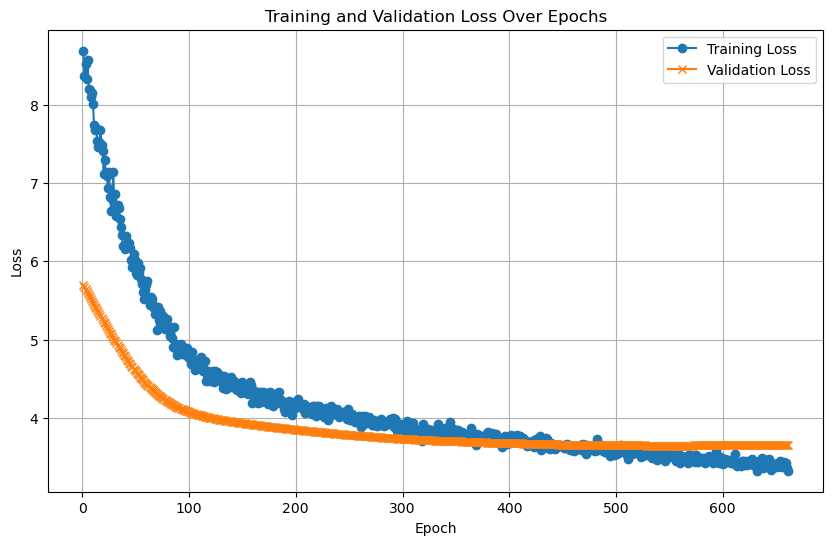

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 4.7142
Test Batch [20/20], Loss: 4.8966

Test Loss: 5.1467


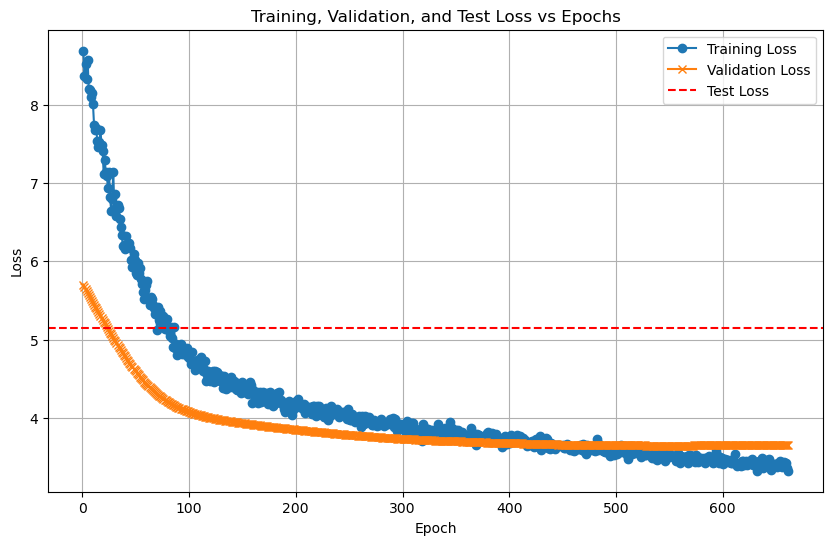

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 35.38%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.25      0.40      0.31         5
           4       0.33      0.20      0.25         5
           5       0.44      0.80      0.57         5
           6       0.44      0.80      0.57         5
           7       0.25      0.60      0.35         5
           8       0.38      0.60      0.46         5
           9       0.00      0.00      0.00         5
          10       0.67      0.80      0.73         5
          11       0.25      0.40      0.31         5
          12       0.00      0.00      0.00         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6727  |  Val Loss: 2.6637
Validation loss improved from inf to 2.6637.
[Epoch 2/1000] Train Loss: 2.6582  |  Val Loss: 2.6579
Validation loss improved from 2.6637 to 2.6579.
[Epoch 3/1000] Train Loss: 2.6499  |  Val Loss: 2.6546
Validation loss improved from 2.6579 to 2.6546.
[Epoch 4/1000] Train Loss: 2.6427  |  Val Loss: 2.6522
Validation loss improved from 2.6546 to 2.6522.
[Epoch 5/1000] Train Loss: 2.6372  |  Val Loss: 2.6502
Validation loss improved from 2.6522 to 2.6502.
[Epoch 6/1000] Train Loss: 2.6324  |  Val Loss: 2.6485
Validation loss improved from 2.6502 to 2.6485.
[Epoch 7/1000] Train Loss: 2.6281  |  Val Loss: 2.6469
Validation loss improved from 2.6485 to 2.6469.
[Epoch 8/1000] Train Loss: 2.6240  |  Val Loss: 2.6457
Validation loss improved from 2.6469 to 2.6457.
[Epoch 9/1000] Train Loss: 2.6205  |  Val Loss: 2.6446
Validation loss improved from 2.6457 to 2.6446.
[Epoch 10/1000] Train Loss: 2.6175  |  Val Loss: 2.6436
Validation loss impr

[Epoch 25/1000] Train Loss: 2.5809  |  Val Loss: 2.6327
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 26/1000] Train Loss: 2.5780  |  Val Loss: 2.6333
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 27/1000] Train Loss: 2.5752  |  Val Loss: 2.6339
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 28/1000] Train Loss: 2.5727  |  Val Loss: 2.6344
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 29/1000] Train Loss: 2.5705  |  Val Loss: 2.6348
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 30/1000] Train Loss: 2.5684  |  Val Loss: 2.6349
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 31/1000] Train Loss: 2.5665  |  Val Loss: 2.6349
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 32/1000] Train Loss: 2.5647  |  Val Loss: 2.6348
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 33/1000] Train Loss: 2.5630  |  Val Loss: 2.6347
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 34/1000] Train Loss: 2.5613  |  Val Loss: 2.6345
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 35/1000] Train Loss: 2.5598  |  Val Loss: 2.6346
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 36/1000] Train Loss: 2.5583  |  Val Loss: 2.6347
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 37/1000] Train Loss: 2.5570  |  Val Loss: 2.6350
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 38/1000] Train Loss: 2.5556  |  Val Loss: 2.6353
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 39/1000] Train Loss: 2.5541  |  Val Loss: 2.6356
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 40/1000] Train Loss: 2.5525  |  Val Loss: 2.6355
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 41/1000] Train Loss: 2.5509  |  Val Loss: 2.6353
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 42/1000] Train Loss: 2.5496  |  Val Loss: 2.6348
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 43/1000] Train Loss: 2.5483  |  Val Loss: 2.6342
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 44/1000] Train Loss: 2.5470  |  Val Loss: 2.6339
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 45/1000] Train Loss: 2.5460  |  Val Loss: 2.6337
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 46/1000] Train Loss: 2.5449  |  Val Loss: 2.6336
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 47/1000] Train Loss: 2.5439  |  Val Loss: 2.6335
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 48/1000] Train Loss: 2.5428  |  Val Loss: 2.6335
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 49/1000] Train Loss: 2.5417  |  Val Loss: 2.6336
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 50/1000] Train Loss: 2.5408  |  Val Loss: 2.6329
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 51/1000] Train Loss: 2.5398  |  Val Loss: 2.6316
Validation loss improved from 2.6316 to 2.6316.
[Epoch 5

[Epoch 67/1000] Train Loss: 2.5269  |  Val Loss: 2.6285
Validation loss improved from 2.6286 to 2.6285.
[Epoch 68/1000] Train Loss: 2.5260  |  Val Loss: 2.6284
Validation loss improved from 2.6285 to 2.6284.
[Epoch 69/1000] Train Loss: 2.5251  |  Val Loss: 2.6281
Validation loss improved from 2.6284 to 2.6281.
[Epoch 70/1000] Train Loss: 2.5242  |  Val Loss: 2.6279
Validation loss improved from 2.6281 to 2.6279.
[Epoch 71/1000] Train Loss: 2.5233  |  Val Loss: 2.6278
Validation loss improved from 2.6279 to 2.6278.
[Epoch 72/1000] Train Loss: 2.5223  |  Val Loss: 2.6282
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 2.5211  |  Val Loss: 2.6290
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 2.5200  |  Val Loss: 2.6299
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 75/1000] Train Loss: 2.5190  |  Val Loss: 2.6307
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 76/1000] Train Loss: 2.5180  |  Val Loss: 2.6314
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 77/1000] Train Loss: 2.5170  |  Val Loss: 2.6321
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 78/1000] Train Loss: 2.5161  |  Val Loss: 2.6328
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 79/1000] Train Loss: 2.5151  |  Val Loss: 2.6340
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 80/1000] Train Loss: 2.5144  |  Val Loss: 2.6357
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 81/1000] Train Loss: 2.5137  |  Val Loss: 2.6376
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 82/1000] Train Loss: 2.5130  |  Val Loss: 2.6393
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 83/1000] Train Loss: 2.5126  |  Val Loss: 2.6409
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 84/1000] Train Loss: 2.5119  |  Val Loss: 2.6421
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 85/1000] Train Loss: 2.5097  |  Val Loss: 2.6430
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 86/1000] Train Loss: 2.5067  |  Val Loss: 2.6440
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 87/1000] Train Loss: 2.5046  |  Val Loss: 2.6445
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 88/1000] Train Loss: 2.5032  |  Val Loss: 2.6443
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 89/1000] Train Loss: 2.5019  |  Val Loss: 2.6441
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 90/1000] Train Loss: 2.5011  |  Val Loss: 2.6414
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 91/1000] Train Loss: 2.4996  |  Val Loss: 2.6367
!! Validation loss did NOT improve !! Patience: 20/100
[

[Epoch 105/1000] Train Loss: 2.4900  |  Val Loss: 2.6259
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 106/1000] Train Loss: 2.4893  |  Val Loss: 2.6261
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 107/1000] Train Loss: 2.4887  |  Val Loss: 2.6261
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 108/1000] Train Loss: 2.4881  |  Val Loss: 2.6262
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 109/1000] Train Loss: 2.4875  |  Val Loss: 2.6263
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 110/1000] Train Loss: 2.4870  |  Val Loss: 2.6263
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 111/1000] Train Loss: 2.4864  |  Val Loss: 2.6264
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 112/1000] Train Loss: 2.4858  |  Val Loss: 2.6265
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 113/1000] Train Loss: 2.4853  |  Val Loss: 2.6267
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 114/1000] Train Loss: 2.4847  |  Val Loss: 2.6270
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 115/1000] Train Loss: 2.4841  |  Val Loss: 2.6275
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 116/1000] Train Loss: 2.4835  |  Val Loss: 2.6279
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 117/1000] Train Loss: 2.4829  |  Val Loss: 2.6281
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 118/1000] Train Loss: 2.4823  |  Val Loss: 2.6283
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 119/1000] Train Loss: 2.4818  |  Val Loss: 2.6288
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 120/1000] Train Loss: 2.4811  |  Val Loss: 2.6297
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 121/1000] Train Loss: 2.4803  |  Val Loss: 2.6304
!! Validation loss did NOT improve !! Patience:

[Epoch 123/1000] Train Loss: 2.4789  |  Val Loss: 2.6317
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 124/1000] Train Loss: 2.4783  |  Val Loss: 2.6324
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 125/1000] Train Loss: 2.4777  |  Val Loss: 2.6332
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 126/1000] Train Loss: 2.4771  |  Val Loss: 2.6338
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 127/1000] Train Loss: 2.4766  |  Val Loss: 2.6344
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 128/1000] Train Loss: 2.4762  |  Val Loss: 2.6350
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 129/1000] Train Loss: 2.4757  |  Val Loss: 2.6358
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 130/1000] Train Loss: 2.4754  |  Val Loss: 2.6373
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 131/1000] Train Loss: 2.4744  |  Val Loss: 2.6395
!! Validation loss did NOT improve !! Patience:

[Epoch 148/1000] Train Loss: 2.4620  |  Val Loss: 2.6681
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 149/1000] Train Loss: 2.4611  |  Val Loss: 2.6679
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 150/1000] Train Loss: 2.4600  |  Val Loss: 2.6675
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 151/1000] Train Loss: 2.4591  |  Val Loss: 2.6672
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 152/1000] Train Loss: 2.4584  |  Val Loss: 2.6669
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 153/1000] Train Loss: 2.4578  |  Val Loss: 2.6681
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 154/1000] Train Loss: 2.4570  |  Val Loss: 2.6706
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 155/1000] Train Loss: 2.4563  |  Val Loss: 2.6727
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 156/1000] Train Loss: 2.4557  |  Val Loss: 2.6742
!! Validation loss did NOT improve !! Patience:

[Epoch 161/1000] Train Loss: 2.4527  |  Val Loss: 2.6809
!! Validation loss did NOT improve !! Patience: 64/100


[Epoch 162/1000] Train Loss: 2.4524  |  Val Loss: 2.6830
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 163/1000] Train Loss: 2.4525  |  Val Loss: 2.6844
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 164/1000] Train Loss: 2.4522  |  Val Loss: 2.6851
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 165/1000] Train Loss: 2.4515  |  Val Loss: 2.6857
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 166/1000] Train Loss: 2.4508  |  Val Loss: 2.6863
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 167/1000] Train Loss: 2.4502  |  Val Loss: 2.6867
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 168/1000] Train Loss: 2.4496  |  Val Loss: 2.6871
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 169/1000] Train Loss: 2.4490  |  Val Loss: 2.6873
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 170/1000] Train Loss: 2.4484  |  Val Loss: 2.6873
!! Validation loss did NOT improve !! Patience:

[Epoch 190/1000] Train Loss: 2.4371  |  Val Loss: 2.6919
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 191/1000] Train Loss: 2.4362  |  Val Loss: 2.6938
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 192/1000] Train Loss: 2.4355  |  Val Loss: 2.6954
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 193/1000] Train Loss: 2.4350  |  Val Loss: 2.6966
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 194/1000] Train Loss: 2.4346  |  Val Loss: 2.6975
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 195/1000] Train Loss: 2.4342  |  Val Loss: 2.6982
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 196/1000] Train Loss: 2.4338  |  Val Loss: 2.6986
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 197/1000] Train Loss: 2.4334  |  Val Loss: 2.6990
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 197 !!
No improvement for 100 epochs.


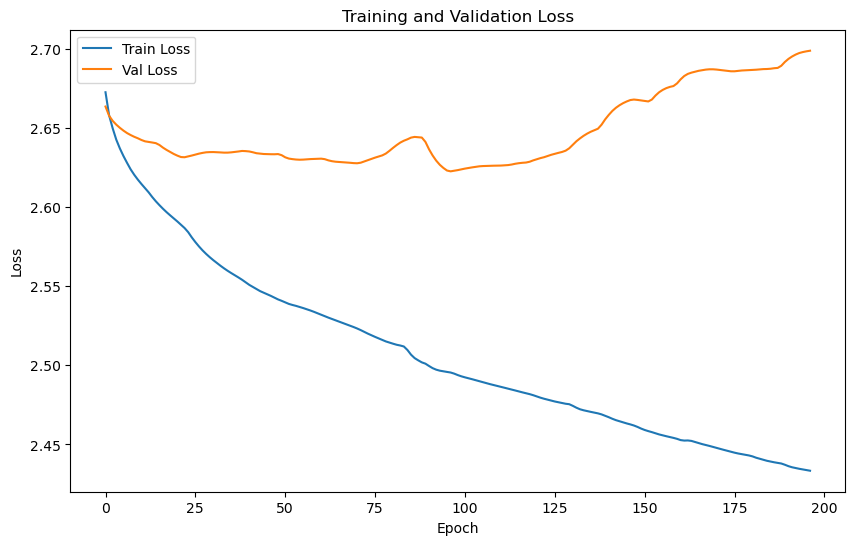

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.5430 | Test Accuracy: 19.64%


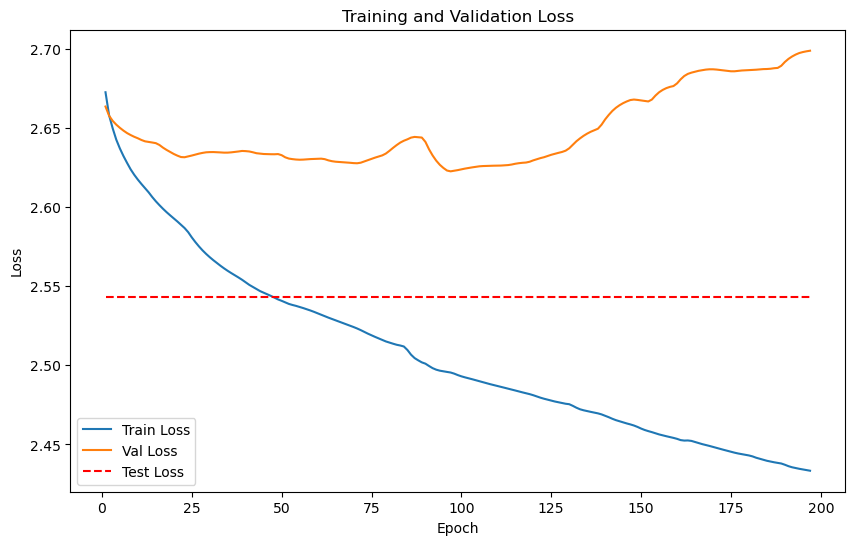

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)


Train embeddings shape: (65, 64), 
Train labels shape: (65,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5081, 64), 
Test labels shape: (5081,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}
Training batch size: 65


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5433
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6266
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5433, Avg Val Loss: 0.5633

Validation loss improved from inf to 0.5633. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.5400
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.6254
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5400, Avg Val Loss: 0.5627

Validation loss improved from 0.5633 to 0.5627. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5397
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.6241
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5397, Avg Val Loss: 0.5621

Validation loss improved from 0.5627 to 0.5621. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.5468
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6228
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5468, Avg Val Loss: 0.5614

Validation loss improved from 0.5621 to 0.5614. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5448
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6219
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5448, Avg Val Loss: 0.5610

Validation loss improved from 0.5614 to 0.5610. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5426
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.6207
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5426, Avg Val Loss: 0.5604

Validation loss improved from 0.5610 to 0.5604. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.5393
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.6195
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5393, Avg Val Loss: 0.5597

Validation loss improved from 0.5604 to 0.5597. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.5441
LOG: Epoch [8/2000] - Validation


    Batch [1/2], Val Loss: 0.6183
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5441, Avg Val Loss: 0.5592

Validation loss improved from 0.5597 to 0.5592. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5407
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.6170
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5407, Avg Val Loss: 0.5585

Validation loss improved from 0.5592 to 0.5585. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5402
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.6154
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5402, Avg Val Loss: 0.5577

Validation loss improved from 0.5585 to 0.5577. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.5435
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.6136
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5435, Avg Val Loss: 0.5568

Validation loss improved from 0.5577 to 0.5568. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.5352
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.6113
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5352, Avg Val Loss: 0.5557

Validation loss improved from 0.5568 to 0.5557. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.5383
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.6091
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5383, Avg Val Loss: 0.5545

Validation loss improved from 0.5557 to 0.5545. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.5334
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.6067
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5334, Avg Val Loss: 0.5534

Validation loss improved from 0.5545 to 0.5534. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.5388
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.6043
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5388, Avg Val Loss: 0.5522

Validation loss improved from 0.5534 to 0.5522. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.5342
LOG: Epoch [16/2000] - Validation


    Batch [1/2], Val Loss: 0.6022
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5342, Avg Val Loss: 0.5511

Validation loss improved from 0.5522 to 0.5511. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.5310
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.6001
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5310, Avg Val Loss: 0.5500

Validation loss improved from 0.5511 to 0.5500. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5349
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5968
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5349, Avg Val Loss: 0.5484

Validation loss improved from 0.5500 to 0.5484. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5296
LOG: Epoch [19/2000] - Validation


    Batch [1/2], Val Loss: 0.5938
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5296, Avg Val Loss: 0.5469

Validation loss improved from 0.5484 to 0.5469. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.5278
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5915
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5278, Avg Val Loss: 0.5457

Validation loss improved from 0.5469 to 0.5457. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.5360
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5896
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5360, Avg Val Loss: 0.5448

Validation loss improved from 0.5457 to 0.5448. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.5285
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.5877
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5285, Avg Val Loss: 0.5438

Validation loss improved from 0.5448 to 0.5438. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.5283
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5858
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5283, Avg Val Loss: 0.5429

Validation loss improved from 0.5438 to 0.5429. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.5335
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5832
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5335, Avg Val Loss: 0.5416

Validation loss improved from 0.5429 to 0.5416. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.5293
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5801
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5293, Avg Val Loss: 0.5401

Validation loss improved from 0.5416 to 0.5401. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.5225
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.5768
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5225, Avg Val Loss: 0.5384

Validation loss improved from 0.5401 to 0.5384. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.5208
LOG: Epoch [27/2000] - Validation


    Batch [1/2], Val Loss: 0.5737
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5208, Avg Val Loss: 0.5368

Validation loss improved from 0.5384 to 0.5368. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.5231
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5703
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5231, Avg Val Loss: 0.5351

Validation loss improved from 0.5368 to 0.5351. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.5236
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5674
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5236, Avg Val Loss: 0.5337

Validation loss improved from 0.5351 to 0.5337. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5248
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.5645
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5248, Avg Val Loss: 0.5323

Validation loss improved from 0.5337 to 0.5323. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.5240
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5620
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5240, Avg Val Loss: 0.5310

Validation loss improved from 0.5323 to 0.5310. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.5259
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5597
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5259, Avg Val Loss: 0.5299

Validation loss improved from 0.5310 to 0.5299. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.5240
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.5575
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5240, Avg Val Loss: 0.5287

Validation loss improved from 0.5299 to 0.5287. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.5222
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5549
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5222, Avg Val Loss: 0.5275

Validation loss improved from 0.5287 to 0.5275. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.5217
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5526
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5217, Avg Val Loss: 0.5263

Validation loss improved from 0.5275 to 0.5263. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5225
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.5505
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5225, Avg Val Loss: 0.5252

Validation loss improved from 0.5263 to 0.5252. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.5252
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5482
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5252, Avg Val Loss: 0.5241

Validation loss improved from 0.5252 to 0.5241. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.5193
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5464
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5193, Avg Val Loss: 0.5232

Validation loss improved from 0.5241 to 0.5232. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.5188
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5451
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5188, Avg Val Loss: 0.5226

Validation loss improved from 0.5232 to 0.5226. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.5211
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.5439
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5211, Avg Val Loss: 0.5220

Validation loss improved from 0.5226 to 0.5220. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5182
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5427
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5182, Avg Val Loss: 0.5214

Validation loss improved from 0.5220 to 0.5214. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.5229
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5416
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5229, Avg Val Loss: 0.5208

Validation loss improved from 0.5214 to 0.5208. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5153
LOG: Epoch [43/2000] - Validation


    Batch [1/2], Val Loss: 0.5403
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5153, Avg Val Loss: 0.5202

Validation loss improved from 0.5208 to 0.5202. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.5155
LOG: Epoch [44/2000] - Validation


    Batch [1/2], Val Loss: 0.5390
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5155, Avg Val Loss: 0.5195

Validation loss improved from 0.5202 to 0.5195. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.5116
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5378
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5116, Avg Val Loss: 0.5189

Validation loss improved from 0.5195 to 0.5189. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.5123
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5366
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5123, Avg Val Loss: 0.5183

Validation loss improved from 0.5189 to 0.5183. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5184
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.5354
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5184, Avg Val Loss: 0.5177

Validation loss improved from 0.5183 to 0.5177. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.5147
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5343
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5147, Avg Val Loss: 0.5171

Validation loss improved from 0.5177 to 0.5171. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.5198
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5331
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5198, Avg Val Loss: 0.5165

Validation loss improved from 0.5171 to 0.5165. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5122
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.5319
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5122, Avg Val Loss: 0.5160

Validation loss improved from 0.5165 to 0.5160. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.5110
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5309
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5110, Avg Val Loss: 0.5154

Validation loss improved from 0.5160 to 0.5154. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.5132
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5299
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5132, Avg Val Loss: 0.5150

Validation loss improved from 0.5154 to 0.5150. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.5132
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.5290
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5132, Avg Val Loss: 0.5145

Validation loss improved from 0.5150 to 0.5145. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5140
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5282
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5140, Avg Val Loss: 0.5141

Validation loss improved from 0.5145 to 0.5141. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.5103
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5275
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5103, Avg Val Loss: 0.5137

Validation loss improved from 0.5141 to 0.5137. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.5139
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5269
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5139, Avg Val Loss: 0.5135

Validation loss improved from 0.5137 to 0.5135. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.5129
LOG: Epoch [57/2000] - Validation


    Batch [1/2], Val Loss: 0.5264
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5129, Avg Val Loss: 0.5132

Validation loss improved from 0.5135 to 0.5132. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.5150
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5150, Avg Val Loss: 0.5129

Validation loss improved from 0.5132 to 0.5129. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.5133
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5252
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5133, Avg Val Loss: 0.5126

Validation loss improved from 0.5129 to 0.5126. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.5107
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5245
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5107, Avg Val Loss: 0.5123

Validation loss improved from 0.5126 to 0.5123. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5100
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5100, Avg Val Loss: 0.5119

Validation loss improved from 0.5123 to 0.5119. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.5063
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5233
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5063, Avg Val Loss: 0.5116

Validation loss improved from 0.5119 to 0.5116. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.5044
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5228
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5044, Avg Val Loss: 0.5114

Validation loss improved from 0.5116 to 0.5114. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.5100
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5100, Avg Val Loss: 0.5111

Validation loss improved from 0.5114 to 0.5111. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.5033
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.5217
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5033, Avg Val Loss: 0.5109

Validation loss improved from 0.5111 to 0.5109. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.5125
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5125, Avg Val Loss: 0.5107

Validation loss improved from 0.5109 to 0.5107. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.5064
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5064, Avg Val Loss: 0.5105

Validation loss improved from 0.5107 to 0.5105. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.5090
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.5205
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5090, Avg Val Loss: 0.5102

Validation loss improved from 0.5105 to 0.5102. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.5072
LOG: Epoch [69/2000] - Validation


    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.5100

Validation loss improved from 0.5102 to 0.5100. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.5068
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.5068, Avg Val Loss: 0.5098

Validation loss improved from 0.5100 to 0.5098. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.5091
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.5091, Avg Val Loss: 0.5096

Validation loss improved from 0.5098 to 0.5096. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.5187
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.5094

Validation loss improved from 0.5096 to 0.5094. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [73/2000] - Validation


    Batch [1/2], Val Loss: 0.5183
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5091

Validation loss improved from 0.5094 to 0.5091. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.5003
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5179
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.5089

Validation loss improved from 0.5091 to 0.5089. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.5079
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.5079, Avg Val Loss: 0.5088

Validation loss improved from 0.5089 to 0.5088. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.5086

Validation loss improved from 0.5088 to 0.5086. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.5072
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.5085

Validation loss improved from 0.5086 to 0.5085. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5084

Validation loss improved from 0.5085 to 0.5084. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.5070
LOG: Epoch [79/2000] - Validation


    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.5070, Avg Val Loss: 0.5083

Validation loss improved from 0.5084 to 0.5083. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.5038
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.5038, Avg Val Loss: 0.5082

Validation loss improved from 0.5083 to 0.5082. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.5057
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.5093
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.5093, Avg Val Loss: 0.5082

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.5069
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.5069, Avg Val Loss: 0.5081

Validation loss improved from 0.5082 to 0.5081. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.5035
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.5071
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.5071, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.5081

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.5080
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.5080, Avg Val Loss: 0.5081

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.5020
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.5020, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.5081

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.5011
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.5011, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.5033
LOG: Epoch [92/2000] - Validation


    Batch [1/2], Val Loss: 0.5161
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.5033, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.5036
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.5161
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.5036, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4982
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5161
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4982, Avg Val Loss: 0.5081

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.5013
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5161
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5080

Validation loss improved from 0.5081 to 0.5080. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.5080

Validation loss improved from 0.5080 to 0.5080. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.5073
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.5073, Avg Val Loss: 0.5080

Validation loss improved from 0.5080 to 0.5080. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.5036
LOG: Epoch [98/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.5036, Avg Val Loss: 0.5079

Validation loss improved from 0.5080 to 0.5079. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.5031
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.5031, Avg Val Loss: 0.5078

Validation loss improved from 0.5079 to 0.5078. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5077

Validation loss improved from 0.5078 to 0.5077. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.5015
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.5015, Avg Val Loss: 0.5076

Validation loss improved from 0.5077 to 0.5076. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.5040
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.5040, Avg Val Loss: 0.5074

Validation loss improved from 0.5076 to 0.5074. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.5016
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.5016, Avg Val Loss: 0.5072

Validation loss improved from 0.5074 to 0.5072. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.5006
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.5006, Avg Val Loss: 0.5070

Validation loss improved from 0.5072 to 0.5070. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.5015
LOG: Epoch [105/2000] - Validation


    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.5015, Avg Val Loss: 0.5069

Validation loss improved from 0.5070 to 0.5069. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.5068

Validation loss improved from 0.5069 to 0.5068. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.5019
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.5019, Avg Val Loss: 0.5067

Validation loss improved from 0.5068 to 0.5067. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.5029
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.5066

Validation loss improved from 0.5067 to 0.5066. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [109/2000] - Validation


    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.4983
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5131
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4983, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4993
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.5065

Validation loss improved from 0.5066 to 0.5065. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.5006
LOG: Epoch [112/2000] - Validation


    Batch [1/2], Val Loss: 0.5128
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.5006, Avg Val Loss: 0.5064

Validation loss improved from 0.5065 to 0.5064. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4984
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4984, Avg Val Loss: 0.5064

Validation loss improved from 0.5064 to 0.5064. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5063

Validation loss improved from 0.5064 to 0.5063. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5063

Validation loss improved from 0.5063 to 0.5063. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5062

Validation loss improved from 0.5063 to 0.5062. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5062

Validation loss improved from 0.5062 to 0.5062. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.5062

Validation loss improved from 0.5062 to 0.5062. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.5066
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.5066, Avg Val Loss: 0.5061

Validation loss improved from 0.5062 to 0.5061. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5061

Validation loss improved from 0.5061 to 0.5061. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4960
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.5061

Validation loss improved from 0.5061 to 0.5061. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.5121
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5061

Validation loss improved from 0.5061 to 0.5061. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4991
LOG: Epoch [123/2000] - Validation


    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4991, Avg Val Loss: 0.5060

Validation loss improved from 0.5061 to 0.5060. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5060

Validation loss improved from 0.5060 to 0.5060. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5060

Validation loss improved from 0.5060 to 0.5060. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5060

Validation loss improved from 0.5060 to 0.5060. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4982
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5118
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4982, Avg Val Loss: 0.5059

Validation loss improved from 0.5060 to 0.5059. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.5116
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5058

Validation loss improved from 0.5059 to 0.5058. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4982
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.5115
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4982, Avg Val Loss: 0.5057

Validation loss improved from 0.5058 to 0.5057. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [130/2000] - Validation


    Batch [1/2], Val Loss: 0.5114
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5057

Validation loss improved from 0.5057 to 0.5057. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.5113
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5057

Validation loss improved from 0.5057 to 0.5057. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5056

Validation loss improved from 0.5057 to 0.5056. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5056

Validation loss improved from 0.5056 to 0.5056. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5056

Validation loss improved from 0.5056 to 0.5056. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [135/2000] - Validation


    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5056

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5056

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5056

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5056

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5055

Validation loss improved from 0.5056 to 0.5055. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.5108
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.5054

Validation loss improved from 0.5055 to 0.5054. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.5106
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5053

Validation loss improved from 0.5054 to 0.5053. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.5105
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5053

Validation loss improved from 0.5053 to 0.5053. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.5103
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5051

Validation loss improved from 0.5053 to 0.5051. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.5100
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5050

Validation loss improved from 0.5051 to 0.5050. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5049

Validation loss improved from 0.5050 to 0.5049. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5048

Validation loss improved from 0.5049 to 0.5048. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5047

Validation loss improved from 0.5048 to 0.5047. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5047

Validation loss improved from 0.5047 to 0.5047. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.5093
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5047

Validation loss improved from 0.5047 to 0.5047. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.5092
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5046

Validation loss improved from 0.5047 to 0.5046. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5045

Validation loss improved from 0.5046 to 0.5045. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [152/2000] - Validation


    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.5044

Validation loss improved from 0.5045 to 0.5044. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5044

Validation loss improved from 0.5044 to 0.5044. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.5043

Validation loss improved from 0.5044 to 0.5043. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5043

Validation loss improved from 0.5043 to 0.5043. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [167/2000] - Validation


    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [168/2000] - Validation


    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [171/2000] - Validation


    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [175/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [176/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [180/2000] - Validation


    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.5043

Validation loss improved from 0.5043 to 0.5043. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.5083
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5042

Validation loss improved from 0.5043 to 0.5042. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.5041

Validation loss improved from 0.5042 to 0.5041. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5040

Validation loss improved from 0.5041 to 0.5040. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.5040

Validation loss improved from 0.5040 to 0.5040. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.5078
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.5039

Validation loss improved from 0.5040 to 0.5039. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.5039

Validation loss improved from 0.5039 to 0.5039. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.5038

Validation loss improved from 0.5039 to 0.5038. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.5038

Validation loss improved from 0.5038 to 0.5038. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5038

Validation loss improved from 0.5038 to 0.5038. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [190/2000] - Validation


    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.5037

Validation loss improved from 0.5038 to 0.5037. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.5037

Validation loss improved from 0.5037 to 0.5037. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [192/2000] - Validation


    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.5037

Validation loss improved from 0.5037 to 0.5037. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.5036

Validation loss improved from 0.5037 to 0.5036. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.5072


    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.5036

Validation loss improved from 0.5036 to 0.5036. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.5036

Validation loss improved from 0.5036 to 0.5036. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [196/2000] - Validation


    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.5036

Validation loss improved from 0.5036 to 0.5036. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.5035

Validation loss improved from 0.5036 to 0.5035. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.5035

Validation loss improved from 0.5035 to 0.5035. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [199/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.5035

Validation loss improved from 0.5035 to 0.5035. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [200/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.5035

Validation loss improved from 0.5035 to 0.5035. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.5035

Validation loss improved from 0.5035 to 0.5035. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.5035

Validation loss improved from 0.5035 to 0.5035. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.5035

Validation loss improved from 0.5035 to 0.5035. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.5069


    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5035

Validation loss improved from 0.5035 to 0.5035. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [205/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.5034

Validation loss improved from 0.5035 to 0.5034. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5034

Validation loss improved from 0.5034 to 0.5034. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [207/2000] - Validation


    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5034

Validation loss improved from 0.5034 to 0.5034. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.5034

Validation loss improved from 0.5034 to 0.5034. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.5034

Validation loss improved from 0.5034 to 0.5034. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.5034

Validation loss improved from 0.5034 to 0.5034. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.5034

Validation loss improved from 0.5034 to 0.5034. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.5034

Validation loss improved from 0.5034 to 0.5034. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.5034

Validation loss improved from 0.5034 to 0.5034. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4750
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [218/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [219/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [231/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [236/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [239/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [240/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [241/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [249/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [252/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [261/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [271/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4751
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [275/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [280/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [296/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [300/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [301/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [302/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.5070


    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [307/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [309/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [311/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 313!!
No improvement for 100 epochs


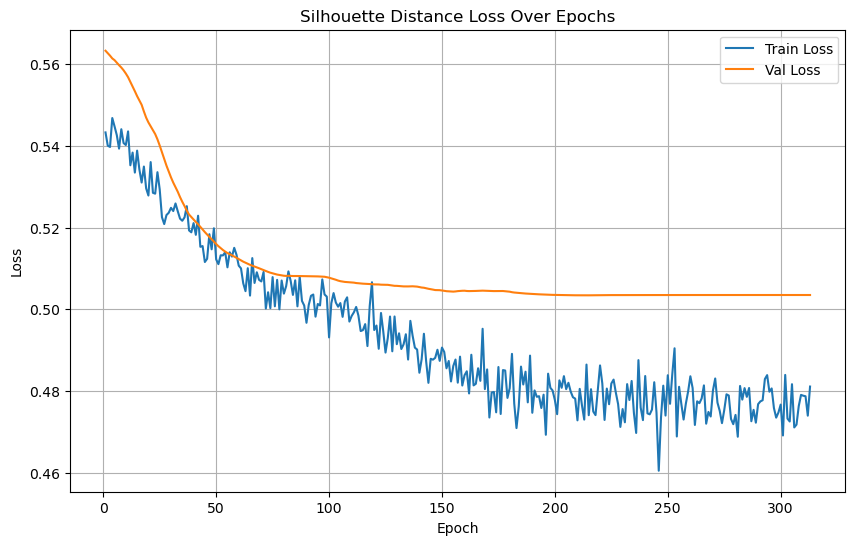

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/80], Loss: 0.3181
Test Batch [20/80], Loss: 0.5000
Test Batch [30/80], Loss: 0.3680
Test Batch [40/80], Loss: 0.2711
Test Batch [50/80], Loss: 0.3333
Test Batch [60/80], Loss: 0.3920


Test Batch [70/80], Loss: 0.4834
Test Batch [80/80], Loss: 0.5000

Test Loss: 0.3304


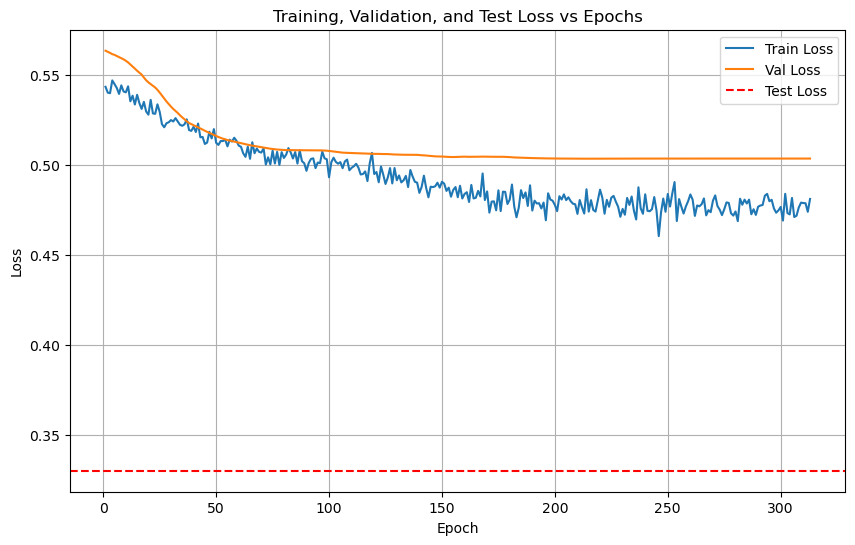

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/80 for test dataset.


  Processed batch 20/80 for test dataset.


  Processed batch 30/80 for test dataset.
  Processed batch 40/80 for test dataset.


  Processed batch 50/80 for test dataset.


  Processed batch 60/80 for test dataset.
  Processed batch 70/80 for test dataset.


  Processed batch 80/80 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 46.15%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.00      0.00      0.00         5
           2       0.20      0.20      0.20         5
           3       0.50      0.20      0.29         5
           4       0.75      0.60      0.67         5
           5       0.80      0.80      0.80         5
           6       0.71      1.00      0.83         5
           7       0.33      0.60      0.43         5
           8       0.36      0.80      0.50         5
           9       0.25      0.20      0.22         5
          10       0.80      0.80      0.80         5
          11       0.00      0.00      0.00         5
          12       0.33      0.20      0.25         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6680  |  Val Loss: 2.8724
Validation loss improved from inf to 2.8724.
[Epoch 2/1000] Train Loss: 2.6597  |  Val Loss: 2.8637
Validation loss improved from 2.8724 to 2.8637.
[Epoch 3/1000] Train Loss: 2.6528  |  Val Loss: 2.8559
Validation loss improved from 2.8637 to 2.8559.
[Epoch 4/1000] Train Loss: 2.6468  |  Val Loss: 2.8488
Validation loss improved from 2.8559 to 2.8488.
[Epoch 5/1000] Train Loss: 2.6414  |  Val Loss: 2.8422
Validation loss improved from 2.8488 to 2.8422.
[Epoch 6/1000] Train Loss: 2.6355  |  Val Loss: 2.8362
Validation loss improved from 2.8422 to 2.8362.
[Epoch 7/1000] Train Loss: 2.6319  |  Val Loss: 2.8310
Validation loss improved from 2.8362 to 2.8310.
[Epoch 8/1000] Train Loss: 2.6280  |  Val Loss: 2.8264
Validation loss improved from 2.8310 to 2.8264.
[Epoch 9/1000] Train Loss: 2.6247  |  Val Loss: 2.8223
Validation loss improved from 2.8264 to 2.8223.
[Epoch 10/1000] Train Loss: 2.6219  |  Val Loss: 2.8186
Validation loss impr

[Epoch 25/1000] Train Loss: 2.5869  |  Val Loss: 2.7787
Validation loss improved from 2.7803 to 2.7787.
[Epoch 26/1000] Train Loss: 2.5853  |  Val Loss: 2.7774
Validation loss improved from 2.7787 to 2.7774.
[Epoch 27/1000] Train Loss: 2.5837  |  Val Loss: 2.7762
Validation loss improved from 2.7774 to 2.7762.
[Epoch 28/1000] Train Loss: 2.5823  |  Val Loss: 2.7751
Validation loss improved from 2.7762 to 2.7751.
[Epoch 29/1000] Train Loss: 2.5807  |  Val Loss: 2.7727
Validation loss improved from 2.7751 to 2.7727.
[Epoch 30/1000] Train Loss: 2.5787  |  Val Loss: 2.7696
Validation loss improved from 2.7727 to 2.7696.
[Epoch 31/1000] Train Loss: 2.5759  |  Val Loss: 2.7669
Validation loss improved from 2.7696 to 2.7669.
[Epoch 32/1000] Train Loss: 2.5733  |  Val Loss: 2.7635
Validation loss improved from 2.7669 to 2.7635.
[Epoch 33/1000] Train Loss: 2.5709  |  Val Loss: 2.7597
Validation loss improved from 2.7635 to 2.7597.
[Epoch 34/1000] Train Loss: 2.5677  |  Val Loss: 2.7566
Validati

[Epoch 36/1000] Train Loss: 2.5621  |  Val Loss: 2.7517
Validation loss improved from 2.7539 to 2.7517.
[Epoch 37/1000] Train Loss: 2.5598  |  Val Loss: 2.7498
Validation loss improved from 2.7517 to 2.7498.
[Epoch 38/1000] Train Loss: 2.5578  |  Val Loss: 2.7482
Validation loss improved from 2.7498 to 2.7482.
[Epoch 39/1000] Train Loss: 2.5559  |  Val Loss: 2.7469
Validation loss improved from 2.7482 to 2.7469.
[Epoch 40/1000] Train Loss: 2.5542  |  Val Loss: 2.7457
Validation loss improved from 2.7469 to 2.7457.
[Epoch 41/1000] Train Loss: 2.5526  |  Val Loss: 2.7447
Validation loss improved from 2.7457 to 2.7447.
[Epoch 42/1000] Train Loss: 2.5511  |  Val Loss: 2.7438
Validation loss improved from 2.7447 to 2.7438.
[Epoch 43/1000] Train Loss: 2.5497  |  Val Loss: 2.7430
Validation loss improved from 2.7438 to 2.7430.
[Epoch 44/1000] Train Loss: 2.5484  |  Val Loss: 2.7423
Validation loss improved from 2.7430 to 2.7423.
[Epoch 45/1000] Train Loss: 2.5470  |  Val Loss: 2.7418
Validati

[Epoch 66/1000] Train Loss: 2.5220  |  Val Loss: 2.7304
Validation loss improved from 2.7308 to 2.7304.
[Epoch 67/1000] Train Loss: 2.5208  |  Val Loss: 2.7301
Validation loss improved from 2.7304 to 2.7301.
[Epoch 68/1000] Train Loss: 2.5196  |  Val Loss: 2.7298
Validation loss improved from 2.7301 to 2.7298.
[Epoch 69/1000] Train Loss: 2.5183  |  Val Loss: 2.7296
Validation loss improved from 2.7298 to 2.7296.
[Epoch 70/1000] Train Loss: 2.5170  |  Val Loss: 2.7295
Validation loss improved from 2.7296 to 2.7295.
[Epoch 71/1000] Train Loss: 2.5157  |  Val Loss: 2.7293
Validation loss improved from 2.7295 to 2.7293.
[Epoch 72/1000] Train Loss: 2.5144  |  Val Loss: 2.7290
Validation loss improved from 2.7293 to 2.7290.
[Epoch 73/1000] Train Loss: 2.5132  |  Val Loss: 2.7287
Validation loss improved from 2.7290 to 2.7287.
[Epoch 74/1000] Train Loss: 2.5120  |  Val Loss: 2.7286
Validation loss improved from 2.7287 to 2.7286.
[Epoch 75/1000] Train Loss: 2.5109  |  Val Loss: 2.7285
Validati

[Epoch 78/1000] Train Loss: 2.5076  |  Val Loss: 2.7280
Validation loss improved from 2.7282 to 2.7280.
[Epoch 79/1000] Train Loss: 2.5064  |  Val Loss: 2.7278
Validation loss improved from 2.7280 to 2.7278.
[Epoch 80/1000] Train Loss: 2.5053  |  Val Loss: 2.7275
Validation loss improved from 2.7278 to 2.7275.
[Epoch 81/1000] Train Loss: 2.5041  |  Val Loss: 2.7272
Validation loss improved from 2.7275 to 2.7272.
[Epoch 82/1000] Train Loss: 2.5030  |  Val Loss: 2.7269
Validation loss improved from 2.7272 to 2.7269.
[Epoch 83/1000] Train Loss: 2.5019  |  Val Loss: 2.7265
Validation loss improved from 2.7269 to 2.7265.
[Epoch 84/1000] Train Loss: 2.5007  |  Val Loss: 2.7259
Validation loss improved from 2.7265 to 2.7259.
[Epoch 85/1000] Train Loss: 2.4996  |  Val Loss: 2.7254
Validation loss improved from 2.7259 to 2.7254.
[Epoch 86/1000] Train Loss: 2.4985  |  Val Loss: 2.7251
Validation loss improved from 2.7254 to 2.7251.
[Epoch 87/1000] Train Loss: 2.4973  |  Val Loss: 2.7248
Validati

[Epoch 109/1000] Train Loss: 2.4704  |  Val Loss: 2.7174
Validation loss improved from 2.7176 to 2.7174.
[Epoch 110/1000] Train Loss: 2.4693  |  Val Loss: 2.7174
Validation loss improved from 2.7174 to 2.7174.
[Epoch 111/1000] Train Loss: 2.4681  |  Val Loss: 2.7175
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 112/1000] Train Loss: 2.4669  |  Val Loss: 2.7176
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 113/1000] Train Loss: 2.4657  |  Val Loss: 2.7177
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 114/1000] Train Loss: 2.4646  |  Val Loss: 2.7176
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 115/1000] Train Loss: 2.4634  |  Val Loss: 2.7174
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 116/1000] Train Loss: 2.4623  |  Val Loss: 2.7171
Validation loss improved from 2.7174 to 2.7171.


[Epoch 117/1000] Train Loss: 2.4611  |  Val Loss: 2.7166
Validation loss improved from 2.7171 to 2.7166.
[Epoch 118/1000] Train Loss: 2.4596  |  Val Loss: 2.7160
Validation loss improved from 2.7166 to 2.7160.
[Epoch 119/1000] Train Loss: 2.4580  |  Val Loss: 2.7157
Validation loss improved from 2.7160 to 2.7157.
[Epoch 120/1000] Train Loss: 2.4564  |  Val Loss: 2.7154
Validation loss improved from 2.7157 to 2.7154.
[Epoch 121/1000] Train Loss: 2.4550  |  Val Loss: 2.7151
Validation loss improved from 2.7154 to 2.7151.
[Epoch 122/1000] Train Loss: 2.4536  |  Val Loss: 2.7148
Validation loss improved from 2.7151 to 2.7148.
[Epoch 123/1000] Train Loss: 2.4522  |  Val Loss: 2.7145
Validation loss improved from 2.7148 to 2.7145.
[Epoch 124/1000] Train Loss: 2.4510  |  Val Loss: 2.7142
Validation loss improved from 2.7145 to 2.7142.
[Epoch 125/1000] Train Loss: 2.4497  |  Val Loss: 2.7138
Validation loss improved from 2.7142 to 2.7138.
[Epoch 126/1000] Train Loss: 2.4484  |  Val Loss: 2.713

[Epoch 149/1000] Train Loss: 2.4199  |  Val Loss: 2.7018
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 150/1000] Train Loss: 2.4189  |  Val Loss: 2.7018
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 151/1000] Train Loss: 2.4179  |  Val Loss: 2.7017
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 152/1000] Train Loss: 2.4167  |  Val Loss: 2.7016
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 153/1000] Train Loss: 2.4151  |  Val Loss: 2.7017
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 154/1000] Train Loss: 2.4137  |  Val Loss: 2.7018
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 155/1000] Train Loss: 2.4123  |  Val Loss: 2.7018
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 156/1000] Train Loss: 2.4109  |  Val Loss: 2.7015
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 157/1000] Train Loss: 2.4094  |  Val Loss: 2.7012
Validation loss improved from 2.7014 to 2.7012.
[Epoch 158/1000] Train Loss: 2.4080  |  Val Loss: 2.7010
Validation loss improved from 2.7012 to 2.7010.
[Epoch 159/1000] Train Loss: 2.4067  |  Val Loss: 2.7008
Validation loss improved from 2.7010 to 2.7008.
[Epoch 160/1000] Train Loss: 2.4054  |  Val Loss: 2.7008
Validation loss improved from 2.7008 to 2.7008.
[Epoch 161/1000] Train Loss: 2.4042  |  Val Loss: 2.7007
Validation loss improved from 2.7008 to 2.7007.
[Epoch 162/1000] Train Loss: 2.4030  |  Val Loss: 2.7008
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 163/1000] Train Loss: 2.4018  |  Val Loss: 2.7010
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 164/1000] Train Loss: 2.4006  |  Val Loss: 2.7014
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 165/1000] Train Loss: 2.3995  |  Val Loss: 2.7018
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 166/1000] Train Loss: 2.

[Epoch 189/1000] Train Loss: 2.3578  |  Val Loss: 2.7412
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 190/1000] Train Loss: 2.3563  |  Val Loss: 2.7423
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 191/1000] Train Loss: 2.3550  |  Val Loss: 2.7433
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 192/1000] Train Loss: 2.3536  |  Val Loss: 2.7443
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 193/1000] Train Loss: 2.3523  |  Val Loss: 2.7451
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 194/1000] Train Loss: 2.3512  |  Val Loss: 2.7458
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 195/1000] Train Loss: 2.3501  |  Val Loss: 2.7461
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 196/1000] Train Loss: 2.3491  |  Val Loss: 2.7464
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 197/1000] Train Loss: 2.3479  |  Val Loss: 2.7468
!! Validation loss did NOT improve !! Patience:

[Epoch 198/1000] Train Loss: 2.3469  |  Val Loss: 2.7474
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 199/1000] Train Loss: 2.3458  |  Val Loss: 2.7481
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 200/1000] Train Loss: 2.3448  |  Val Loss: 2.7486
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 201/1000] Train Loss: 2.3435  |  Val Loss: 2.7489
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 202/1000] Train Loss: 2.3419  |  Val Loss: 2.7493
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 203/1000] Train Loss: 2.3405  |  Val Loss: 2.7496
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 204/1000] Train Loss: 2.3391  |  Val Loss: 2.7498
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 205/1000] Train Loss: 2.3377  |  Val Loss: 2.7501
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 206/1000] Train Loss: 2.3364  |  Val Loss: 2.7505
!! Validation loss did NOT improve !! Patience:

[Epoch 232/1000] Train Loss: 2.3038  |  Val Loss: 2.8039
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 233/1000] Train Loss: 2.3028  |  Val Loss: 2.8048
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 234/1000] Train Loss: 2.3017  |  Val Loss: 2.8054
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 235/1000] Train Loss: 2.3005  |  Val Loss: 2.8059
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 236/1000] Train Loss: 2.2993  |  Val Loss: 2.8064
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 237/1000] Train Loss: 2.2981  |  Val Loss: 2.8069
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 238/1000] Train Loss: 2.2969  |  Val Loss: 2.8073
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 239/1000] Train Loss: 2.2958  |  Val Loss: 2.8078
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 240/1000] Train Loss: 2.2947  |  Val Loss: 2.8082
!! Validation loss did NOT improve !! Patience:

[Epoch 241/1000] Train Loss: 2.2937  |  Val Loss: 2.8087
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 242/1000] Train Loss: 2.2927  |  Val Loss: 2.8092
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 243/1000] Train Loss: 2.2918  |  Val Loss: 2.8097
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 244/1000] Train Loss: 2.2909  |  Val Loss: 2.8102
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 245/1000] Train Loss: 2.2900  |  Val Loss: 2.8105
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 246/1000] Train Loss: 2.2892  |  Val Loss: 2.8108
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 247/1000] Train Loss: 2.2884  |  Val Loss: 2.8130
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 248/1000] Train Loss: 2.2873  |  Val Loss: 2.8166
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 249/1000] Train Loss: 2.2860  |  Val Loss: 2.8196
!! Validation loss did NOT improve !! Patience:

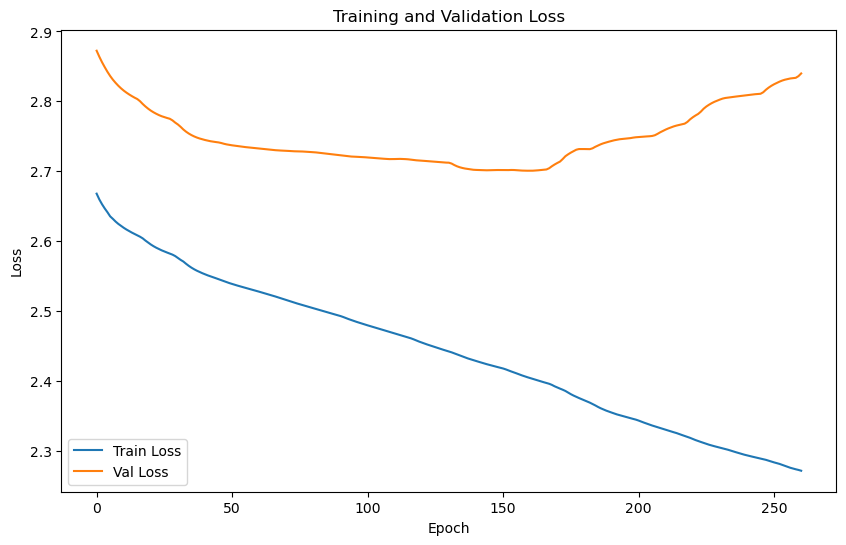

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.4920 | Test Accuracy: 40.70%


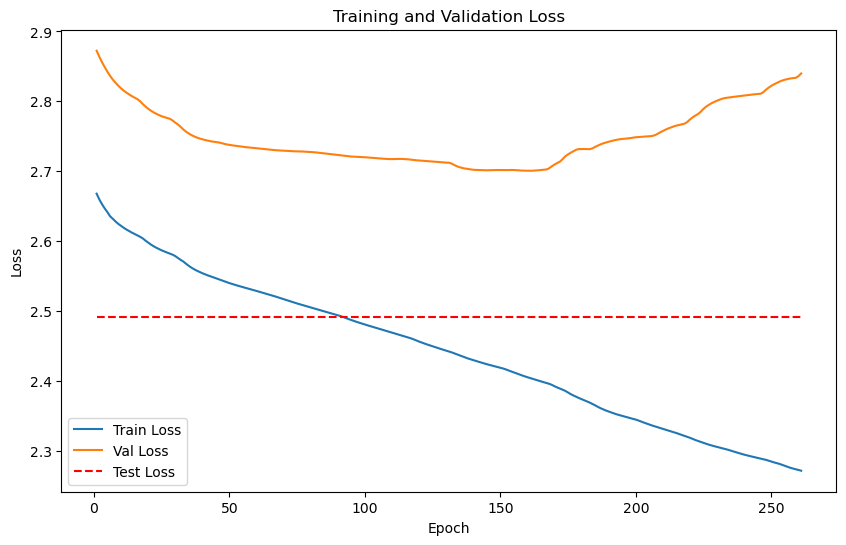

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


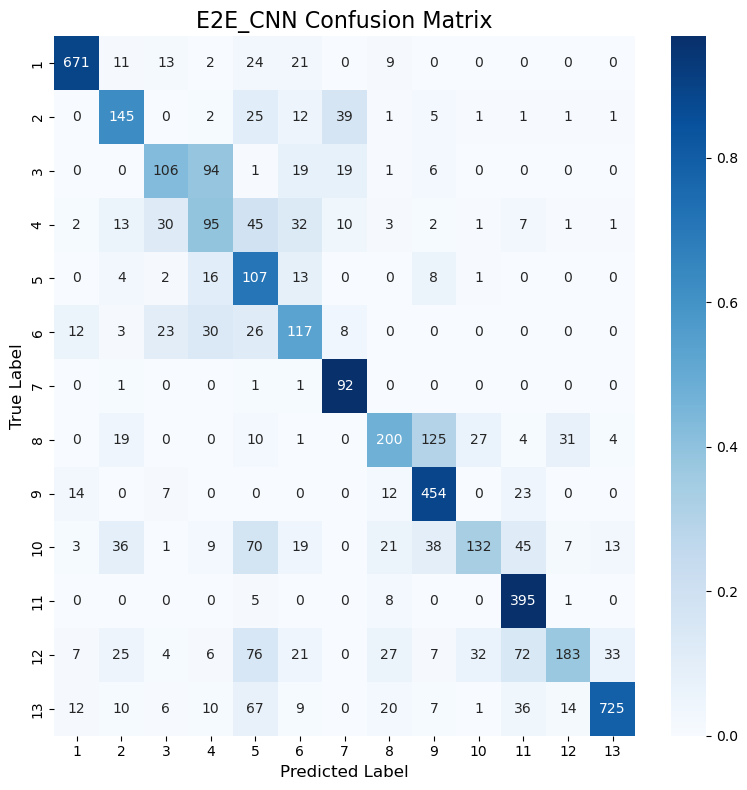

Classification Accuracy: 67.35%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


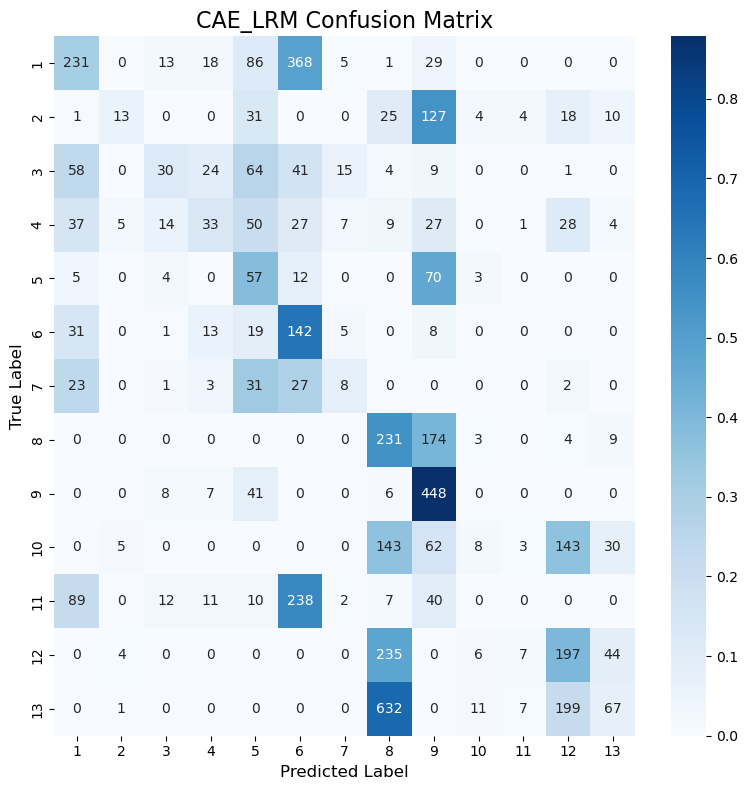

Classification Accuracy: 28.83%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


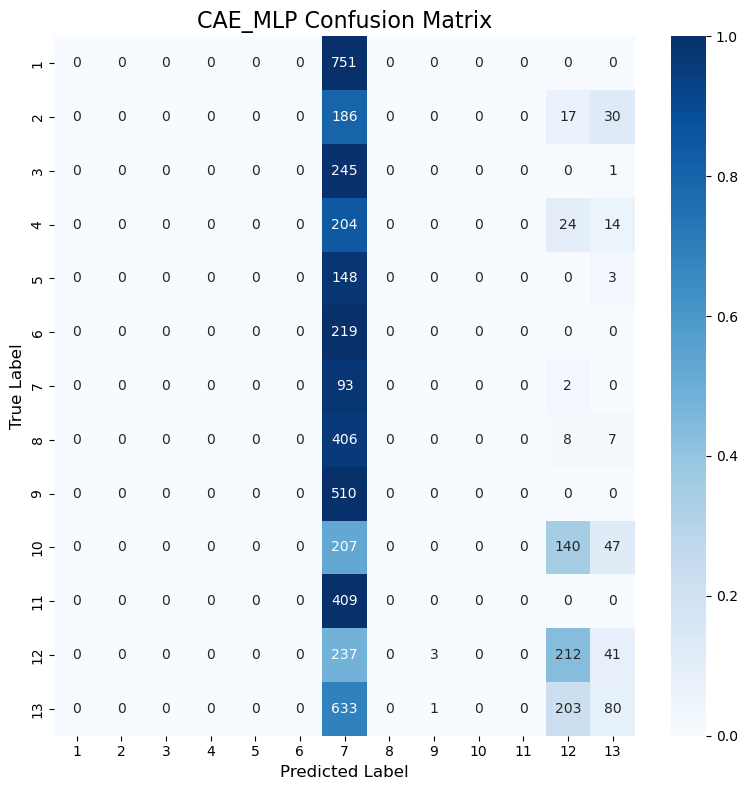

Classification Accuracy: 7.58%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


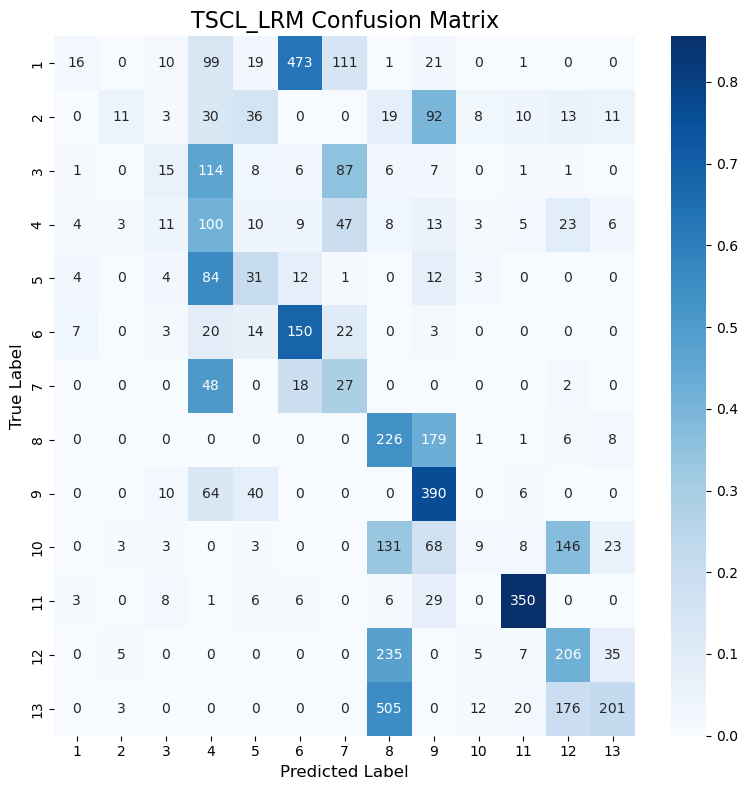

Classification Accuracy: 34.09%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


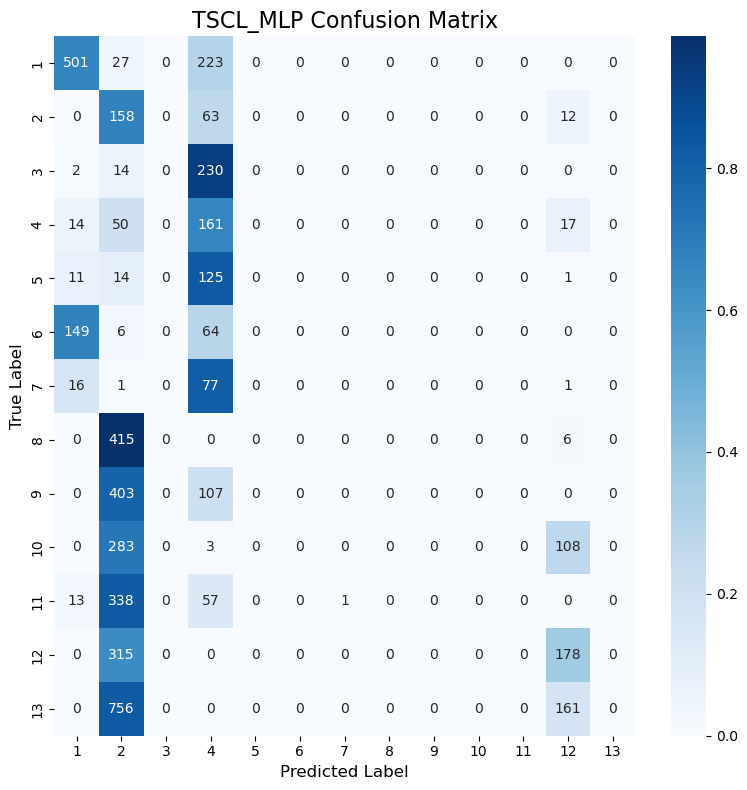

Classification Accuracy: 19.64%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


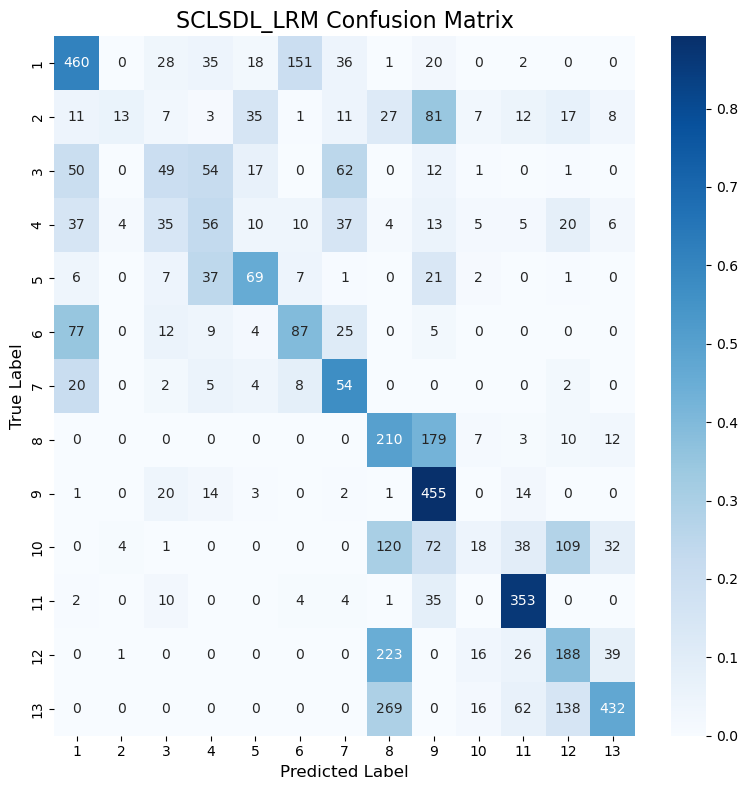

Classification Accuracy: 48.10%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


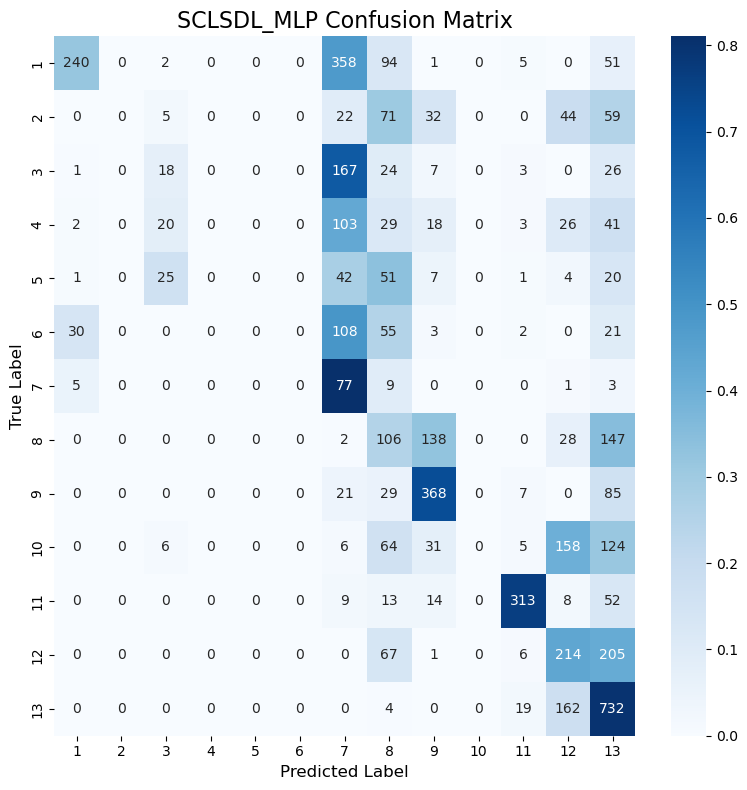

Classification Accuracy: 40.70%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          67.35
1    LRM (CAE)          28.83
2    MLP (CAE)           7.58
3     TSCL LRM          34.09
4     TSCL MLP          19.64
5  SCL_SDL LRM          48.10
6  SCL_SDL MLP          40.70

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          67.35
5  SCL_SDL LRM          48.10
6  SCL_SDL MLP          40.70
3     TSCL LRM          34.09
1    LRM (CAE)          28.83
4     TSCL MLP          19.64
2    MLP (CAE)           7.58
